# Chapter 3.5 and 4 - Experimentation and Results
This notebook contains the code on the univariate experiments conducted as the core part of my thesis. Together with the notebook on multivariate models it serves as the baseline both for Chapter 3.4 covering the approach that was pursued in the experiments as well as for Chapter 4 presenting the results from the experiments. Note that the experimentation focused on the prototypes of each dataset group i.e., dataset C4, C6 and C1.

## Initialization

In [ ]:
# set up connection to Google Sheets to access the datasets
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import math
from sklearn.metrics import mean_squared_error, explained_variance_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# code for resetting pyplot formats (only used for plot unified creation)
import matplotlib
matplotlib.rc_file_defaults()

In [ ]:
# settings for unified format across plots
import matplotlib.pylab as pylab
params = {'legend.fontsize': 20,
          'figure.figsize': (15, 7.5),
         'axes.labelsize': 16,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14}
pylab.rcParams.update(params)

## Group 1 - prototype dataset C4

C4 is characterized by being the longest dataset and including low volatility with only few outliers.

In [ ]:
# load Sales model data from Google Sheets
worksheet = gc.open('C4').sheet1
rows = worksheet.get_all_values()

# convert to dataframe
df = pd.DataFrame.from_records(rows[1:],columns=rows[0])
df['VALUE'] = pd.to_numeric(df['VALUE'])
df['DATE'] = pd.to_datetime(df['DATE'])
df.head()

In [ ]:
# Group and pivot data
df = pd.DataFrame(df.groupby(['DATE','METRIC'])['VALUE'].sum()).reset_index()
df = df.pivot(index=['DATE'],columns=['METRIC'],values=['VALUE'])
df.columns = [col[1] for col in df.columns]

# filter DataFrame to only keep data WON_REVENUE
df = df[['WON_REVENUE']].dropna()
df.head()

### SARIMAX

In [ ]:
# SARIMAX-specific imports
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog, df_val=None):
    """
        Return dataframe with parameters, corresponding AIC or validation error (MSE) 
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
        df_val - validation set
    """
    
    results = []
    
    if type(df_val) == type(None):
        for param in tqdm_notebook(parameters_list):
            try: 
                model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
            except:
                continue

            try:
                aicc = model.aicc
                results.append([param, aicc])
            except:
                continue
        
        result_df = pd.DataFrame(results)
        result_df.columns = ['(p,q)x(P,Q)', 'AICc']
        #Sort by AIC in ascending order, lower is better in both cases
        result_df = result_df.sort_values(by='AICc', ascending=True).reset_index(drop=True)
    
    
    else:
        for param in tqdm_notebook(parameters_list):
                try: 
                    model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
                except:
                    continue

                pred = model.predict(start=pd.to_datetime("2021-01-01"), end=pd.to_datetime("2021-12-01"))
                val_loss = mean_squared_error(df_val, pred)

                results.append([param, val_loss])

        result_df = pd.DataFrame(results)
        result_df.columns = ['(p,q)x(P,Q)', 'val loss']
        #Sort by val loss in ascending order, lower is better in both cases
        result_df = result_df.sort_values(by='val loss', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
# create parameters list for grid search
p = range(0, 4, 1)
q = range(0, 4, 1)
P = range(0, 4, 1)
Q = range(0, 4, 1)
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


#### Full series
On the full series data, both a heuristics as well as an optimization approach were pursued.


In [ ]:
# split data
df_train = df.iloc[:-12]
df_test = df.iloc[-12:]

In [ ]:
# plot full series
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(df_train)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.xlabel('DATE', fontsize=20)
plt.grid(axis='y')
plt.show()

##### Heuristics
For the heuristics approach, based on the results from the EDA, we conduct a grid search on the undifferenced series optimizing for the achieved AICc.

In [ ]:
# zero differencing grid search (heuristics approach)
result_df = optimize_SARIMA(parameters_list, 0, 0, 12, df_train['WON_REVENUE'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AICc
0,"(1, 1, 0, 0)",1888.139270
1,"(2, 1, 0, 0)",1889.025172
2,"(2, 2, 0, 0)",1889.707357
3,"(1, 2, 0, 0)",1890.225538
4,"(1, 1, 1, 0)",1890.323307
...,...,...
251,"(0, 3, 3, 3)",1916.553822
252,"(0, 0, 3, 2)",1935.187457
253,"(0, 0, 1, 2)",1942.074524
254,"(0, 0, 0, 2)",1942.690861


In [ ]:
# train heuristics model (1, 0, 1)x(0, 0, 0, 12)
model_heuristic = SARIMAX(df_train['WON_REVENUE'], order=(1, 0, 1), seasonal_order=(0, 0, 0, 12)).fit(dis=-1)

In [ ]:
# print model summary
model_heuristic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            WON_REVENUE   No. Observations:                   89
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -940.928
Date:                Tue, 25 Apr 2023   AIC                           1887.857
Time:                        15:25:15   BIC                           1895.323
Sample:                    08-01-2014   HQIC                          1890.866
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9933      0.048     20.666      0.000       0.899       1.087
ma.L1         -0.9294      0.221     -4.215      0.000      -1.362      -0.497
sigma2      1.029e+08   1.42e-09   7.25e+16      0.000    1.03e+08    1.03e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):              4330.78
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):              12.02   Skew:                             5.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.25e+34. Standard errors may be unstable.
"""

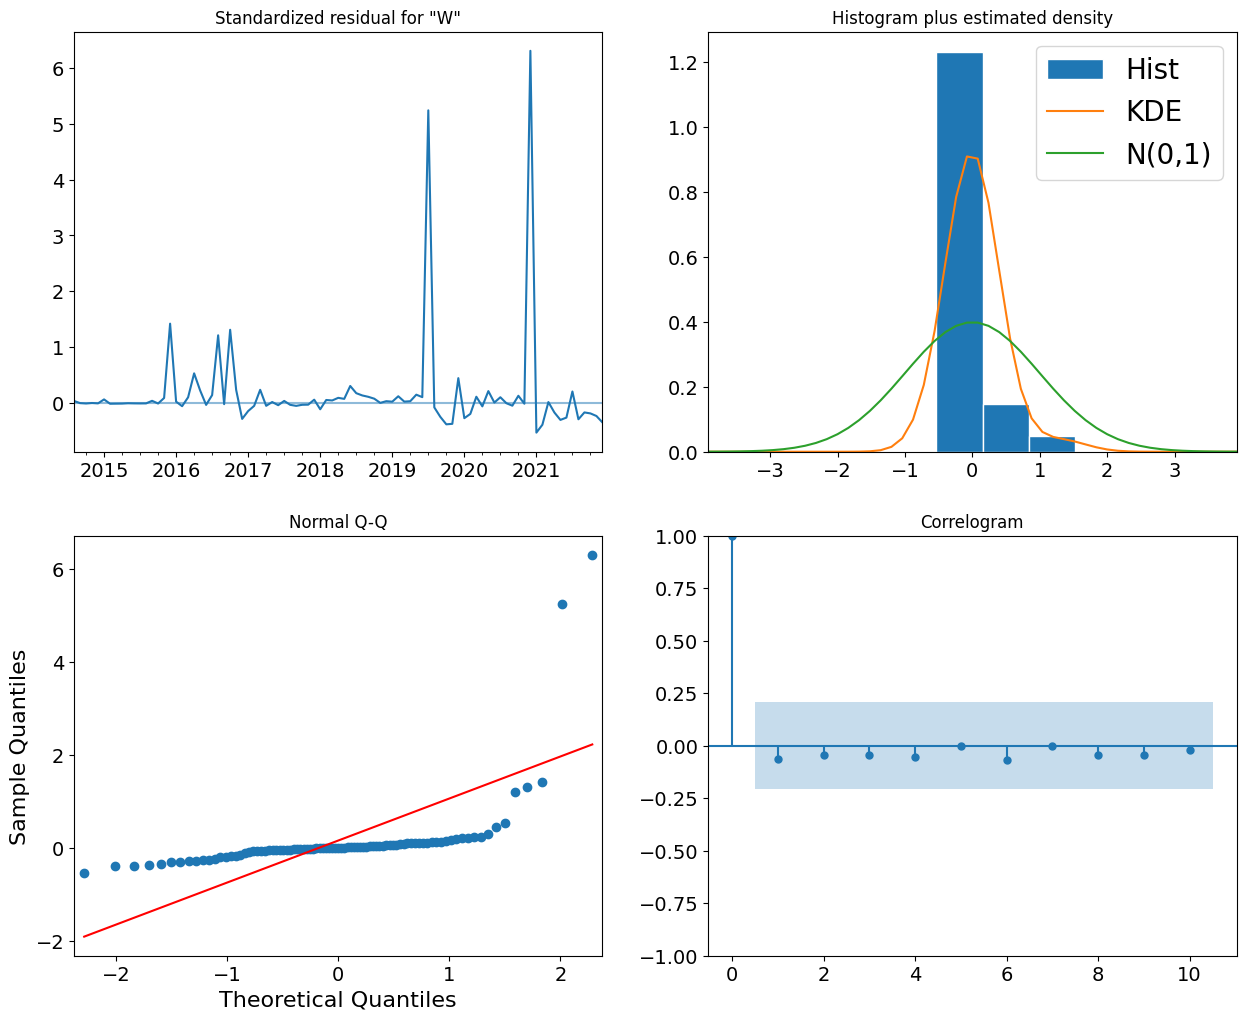

In [ ]:
# plot residual diagnostics
model_heuristic.plot_diagnostics(figsize=(15,12));

In [ ]:
# forecast for heuristic model
df_train['arima_model'] = [x if x > 0 else 0 for x in model_heuristic.fittedvalues]
forecast_heuristic = model_heuristic.predict(start=pd.to_datetime("2022-01-01"), end=pd.to_datetime("2022-12-01"))
forecast_heuristic = df_train['arima_model'].append(forecast_heuristic)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast_heuristic, color='r', label='model')
plt.axvspan(df_test.index[0], forecast_heuristic.index[-1], alpha=0.5, color='lightgrey')
plt.grid(axis='y')
plt.plot(df['WON_REVENUE'], label='actual')
plt.xlabel('DATE', fontsize=20)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.legend()
plt.show()

In [ ]:
print('RMSE for heuristic model:',math.sqrt(mean_squared_error(df_test['WON_REVENUE'], forecast_heuristic[-12:])))
print('Explained variance for heuristic model:',explained_variance_score(df_test['WON_REVENUE'], forecast_heuristic[-12:]))

RMSE for heuristic model: 2486.2241817748563
Explained variance for heuristic model: 0.023952259250285657


##### Optimized
In the optimization approach, instead of only searching for the best model within the given differencing order, I looped through all possible combinations of (p,d,q)x(P,D,Q). Further, a validation split of 12 periods was introduced to the train set to optimize for the validation loss.

In [ ]:
# split data again to retrieve validation split
df_train = df.iloc[:-24]
df_val = df.iloc[-24:-12]

In [ ]:
# zero differencing grid search (optimization approach)
result_df = optimize_SARIMA(parameters_list, 0, 0, 12, df_train['WON_REVENUE'], df_val['WON_REVENUE'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",val loss
0,"(1, 3, 3, 3)",1.005816e+07
1,"(1, 3, 1, 1)",1.570204e+07
2,"(1, 3, 1, 2)",1.818470e+07
3,"(1, 3, 2, 3)",1.827667e+07
4,"(1, 3, 0, 2)",1.906601e+07
...,...,...
250,"(1, 0, 0, 0)",8.670040e+07
251,"(3, 0, 0, 0)",8.865884e+07
252,"(2, 0, 0, 0)",9.056708e+07
253,"(0, 0, 1, 2)",9.076985e+07


In [ ]:
# d = 1; D = 0 grid search (optimization approach)
result_df = optimize_SARIMA(parameters_list, 1, 0, 12, df_train['WON_REVENUE'], df_val['WON_REVENUE'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",val loss
0,"(2, 2, 3, 1)",3.167240e+07
1,"(2, 2, 1, 1)",3.534162e+07
2,"(0, 1, 0, 0)",4.428845e+07
3,"(2, 2, 0, 0)",4.467453e+07
4,"(3, 1, 0, 0)",4.482659e+07
...,...,...
249,"(0, 0, 3, 0)",4.046874e+09
250,"(0, 0, 2, 0)",4.050255e+09
251,"(0, 0, 2, 1)",4.056807e+09
252,"(0, 0, 1, 3)",4.060054e+09


In [ ]:
# d = 2; D = 0 grid search (optimization approach)
result_df = optimize_SARIMA(parameters_list, 2, 0, 12, df_train['WON_REVENUE'], df_val['WON_REVENUE'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",val loss
0,"(2, 3, 0, 0)",2.478267e+07
1,"(0, 3, 1, 0)",3.640639e+07
2,"(0, 2, 1, 0)",3.723072e+07
3,"(0, 2, 1, 1)",3.822100e+07
4,"(1, 3, 0, 0)",3.928191e+07
...,...,...
249,"(0, 0, 3, 2)",2.796192e+11
250,"(0, 0, 0, 0)",2.796192e+11
251,"(0, 0, 1, 2)",2.799375e+11
252,"(0, 0, 3, 1)",2.807872e+11


In [ ]:
# d = 0; D = 1 grid search (optimization approach)
result_df = optimize_SARIMA(parameters_list, 0, 1, 12, df_train['WON_REVENUE'], df_val['WON_REVENUE'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",val loss
0,"(2, 2, 1, 1)",5.624092e+07
1,"(2, 2, 0, 1)",6.260330e+07
2,"(2, 2, 0, 2)",6.859295e+07
3,"(1, 1, 0, 2)",7.110299e+07
4,"(3, 1, 0, 2)",7.229898e+07
...,...,...
251,"(0, 3, 0, 0)",3.624165e+08
252,"(1, 3, 0, 0)",3.624400e+08
253,"(2, 1, 0, 0)",3.806398e+08
254,"(3, 2, 0, 0)",3.860887e+08


In [ ]:
# d = 1; D = 1 grid search (optimization approach)
result_df = optimize_SARIMA(parameters_list, 1, 1, 12, df_train['WON_REVENUE'], df_val['WON_REVENUE'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",val loss
0,"(0, 2, 0, 2)",5.753843e+07
1,"(0, 1, 0, 2)",5.756568e+07
2,"(0, 3, 0, 2)",5.793913e+07
3,"(1, 3, 0, 2)",5.936275e+07
4,"(0, 1, 0, 1)",6.652052e+07
...,...,...
250,"(0, 0, 3, 1)",4.593803e+09
251,"(0, 0, 2, 1)",4.594964e+09
252,"(0, 0, 3, 0)",4.669416e+09
253,"(0, 0, 2, 0)",4.680712e+09


In [ ]:
# d = 2; D = 1 grid search (optimization approach)
result_df = optimize_SARIMA(parameters_list, 2, 1, 12, df_train['WON_REVENUE'], df_val['WON_REVENUE'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",val loss
0,"(2, 2, 1, 0)",4.427344e+07
1,"(0, 2, 0, 2)",1.004557e+08
2,"(1, 3, 0, 1)",1.111790e+08
3,"(2, 2, 0, 2)",1.444920e+08
4,"(0, 2, 2, 2)",1.501308e+08
...,...,...
249,"(0, 0, 1, 2)",2.795456e+11
250,"(0, 0, 3, 0)",2.812328e+11
251,"(1, 3, 1, 1)",2.194340e+12
252,"(3, 1, 1, 1)",3.643219e+12


In [ ]:
# remove validation split so that train set covers full training data again
df_train = df.iloc[:-12]

In [ ]:
# train optimized model (0, 2, 2)x(0, 1, 1, 12)
model_optimal = SARIMAX(df_train['WON_REVENUE'], order=(1, 0, 3), seasonal_order=(3, 0, 3, 12)).fit(dis=-1)

In [ ]:
# print model summary
model_optimal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        WON_REVENUE   No. Observations:                   89
Model:             SARIMAX(1, 0, 3)x(3, 0, 3, 12)   Log Likelihood                -940.714
Date:                            Sat, 22 Apr 2023   AIC                           1903.427
Time:                                    12:18:21   BIC                           1930.802
Sample:                                08-01-2014   HQIC                          1914.462
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9923      0.145      6.844      0.000       0.708       1.276
ma.L1         -0.9618      0.601     -1.599      0.110      -2.140       0.217
ma.L2          0.0178      0.611      0.029      0.977      -1.179       1.214
ma.L3          0.0140      0.422      0.033      0.974      -0.813       0.841
ar.S.L12      -0.6573     18.251     -0.036      0.971     -36.428      35.114
ar.S.L24       0.5929     24.508      0.024      0.981     -47.443      48.629
ar.S.L36       0.6367     23.408      0.027      0.978     -45.243      46.516
ma.S.L12       0.6627     18.497      0.036      0.971     -35.591      36.916
ma.S.L24      -0.5822     25.712     -0.023      0.982     -50.977      49.813
ma.S.L36      -0.5529     24.805     -0.022      0.982     -49.169      48.063
sigma2       1.06e+08   2.15e-05   4.92e+12      0.000    1.06e+08    1.06e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              4217.07
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):              11.77   Skew:                             5.52
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  3e+28. Standard errors may be unstable.
"""

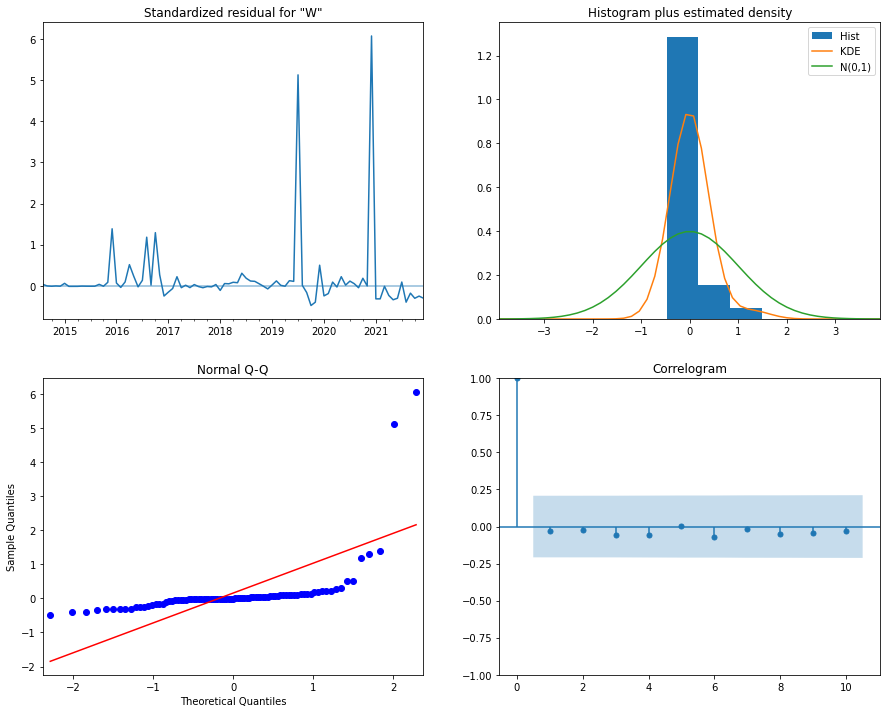

In [ ]:
# plot residuals diagnostics
model_optimal.plot_diagnostics(figsize=(15,12));

In [ ]:
# forecast for optimal model
df_train['arima_model'] = [x if x > 0 else 0 for x in model_optimal.fittedvalues]
forecast_optimal = model_optimal.predict(start=pd.to_datetime("2022-01-01"), end=pd.to_datetime("2022-12-01"))
forecast_optimal = df_train['arima_model'].append(forecast_optimal)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast_optimal, color='r', label='model')
plt.axvspan(df_train.index[-1], forecast_optimal.index[-1], alpha=0.5, color='lightgrey')
plt.plot(df['WON_REVENUE'], label='actual')
plt.grid(axis='y')
plt.xlabel('DATE', fontsize=20)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.legend()
plt.show()

In [ ]:
print('RMSE for optimal model:',math.sqrt(mean_squared_error(df_test['WON_REVENUE'], forecast_optimal[-12:])))
print('Explained variance for optimal model:',explained_variance_score(df_test['WON_REVENUE'], forecast_optimal[-12:]))

RMSE for optimal model: 2783.8417252585527
Explained variance for optimal model: -0.8707266875852537


#### 2 years window
For the 2 years series, I only pursued a heuristics approach due to the reduced number of data points. Thus, based on the results from the EDA, we conduct a grid search on the undifferenced series optimizing for the achieved AICc.

In [ ]:
# shorten dataset to only retain most recent three years (2 years of training data + 1 year of test data)
df_shortened = df[-36:]

In [ ]:
# split data
df_train = df_shortened.iloc[:-12]
df_test = df_shortened.iloc[-12:]

In [ ]:
# plot 2-year train series
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(df_train)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.xlabel('DATE', fontsize=20)
plt.grid(axis='y')
plt.show()

In [ ]:
# zero differencing
result_df = optimize_SARIMA(parameters_list, 0, 0, 12, df_train['WON_REVENUE'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AICc
0,"(0, 0, 3, 0)",10.105263
1,"(1, 1, 0, 0)",532.721482
2,"(0, 0, 0, 0)",533.609949
3,"(1, 0, 0, 0)",534.298118
4,"(0, 0, 1, 0)",535.209010
...,...,...
248,"(1, 3, 1, 0)",717.751687
249,"(3, 3, 0, 0)",725.362178
250,"(3, 3, 1, 0)",736.380556
251,"(2, 3, 0, 0)",757.772560


In [ ]:
# train heuristics model (1, 0, 1)x(0, 0, 0, 12)
model_heuristic = SARIMAX(df_train['WON_REVENUE'], order=(1, 0, 1), seasonal_order=(0, 0, 0, 12)).fit(dis=-1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# print model summary
model_heuristic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            WON_REVENUE   No. Observations:                   24
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -262.761
Date:                Mon, 24 Apr 2023   AIC                            531.521
Time:                        18:44:27   BIC                            535.056
Sample:                    01-01-2020   HQIC                           532.459
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.006    160.101      0.000       0.988       1.012
ma.L1         -0.9910      0.312     -3.174      0.002      -1.603      -0.379
sigma2      1.725e+08   1.95e-09   8.86e+16      0.000    1.73e+08    1.73e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               363.45
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             4.24
Prob(H) (two-sided):                  0.66   Kurtosis:                        20.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.19e+33. Standard errors may be unstable.
"""

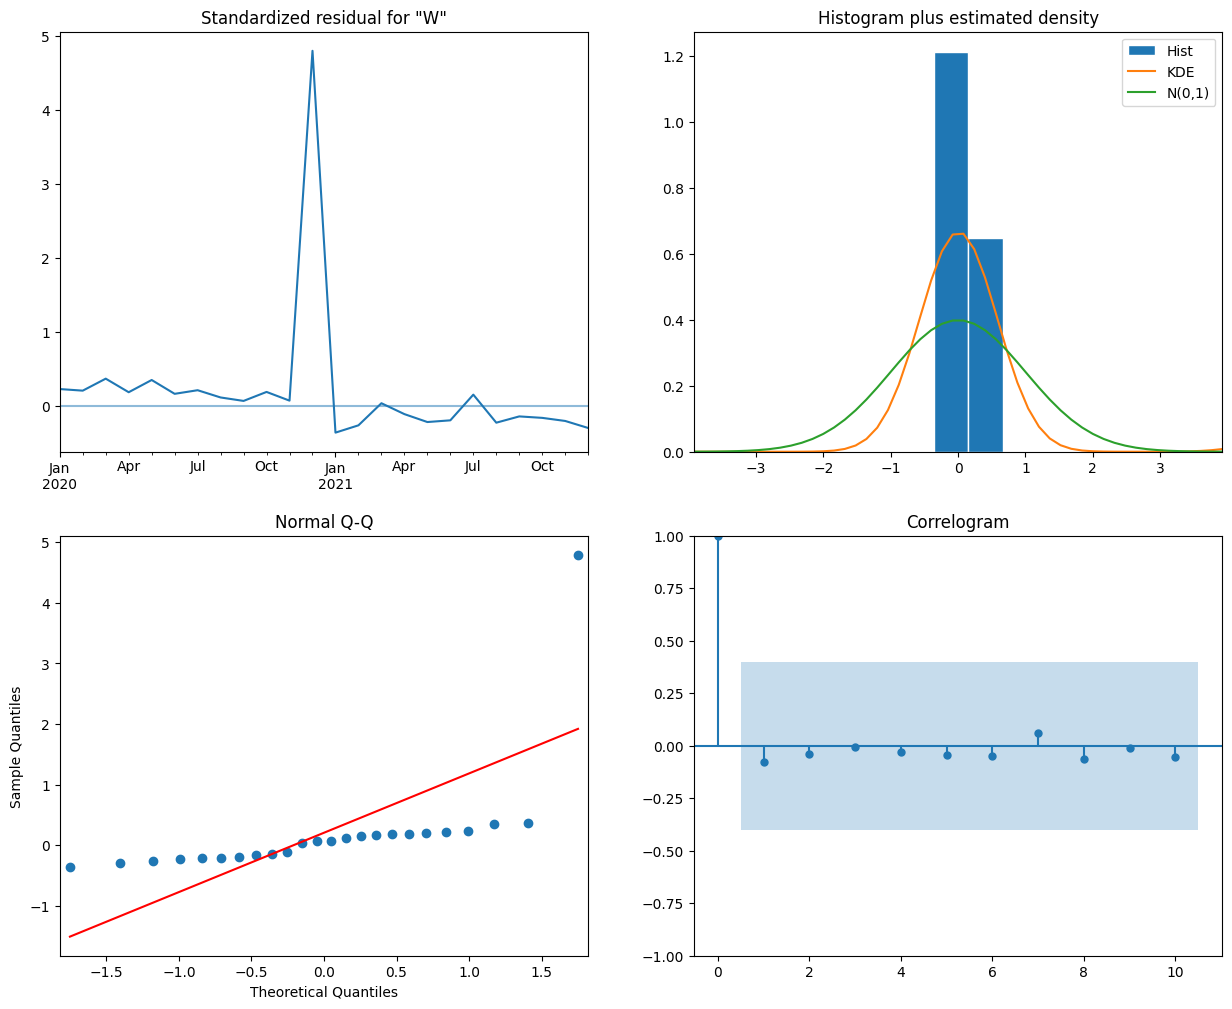

In [ ]:
# plot residual diagnostics
model_heuristic.plot_diagnostics(figsize=(15,12));

In [ ]:
# forecast for heuristic model
df_train['arima_model'] = [x if x > 0 else 0 for x in model_heuristic.fittedvalues]
forecast_heuristic = model_heuristic.predict(start=pd.to_datetime("2022-01-01"), end=pd.to_datetime("2022-12-01"))
forecast_heuristic = df_train['arima_model'].append(forecast_heuristic)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast_heuristic, color='r', label='model')
plt.axvspan(df_test.index[0], forecast_heuristic.index[-1], alpha=0.5, color='lightgrey')
plt.plot(df_shortened['WON_REVENUE'], label='actual')
plt.grid(axis='y')
plt.xlabel('DATE', fontsize=20)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.legend()
plt.show()

In [ ]:
print('RMSE for heuristic model:',math.sqrt(mean_squared_error(df_test['WON_REVENUE'], forecast_heuristic[-12:])))
print('Explained variance for heuristic model:',explained_variance_score(df_test['WON_REVENUE'], forecast_heuristic[-12:]))

RMSE for heuristic model: 1950.522192791329
Explained variance for heuristic model: 0.0005746477034873632


### Neural-Prophet

In [ ]:
# clone NeuralProphet git repository
!git clone https://github.com/ourownstory/neural_prophet.git

In [ ]:
cd neural_prophet

In [ ]:
# install NeuralProphet repository
pip install .[live]

In [ ]:
# import NeuralProphet functionality
from neuralprophet import NeuralProphet

In [ ]:
# ensuring reproducibility of results
from neuralprophet import set_random_seed 

In [ ]:
# adjust data format to NP requirements
df = df.reset_index()
df.columns = ['ds','y']
df

#### Full series
On the full series data, both a heuristics as well as an optimization approach were pursued.

In [ ]:
# split data
df_train = df[:-12]
df_test = df[-12:]

In [ ]:
# create enlarged train series for prediction generation
enlarged_df = df_train.append(pd.DataFrame({'ds':[pd.Timestamp('2022-01-01'),pd.Timestamp('2022-02-01'),pd.Timestamp('2022-03-01'),pd.Timestamp('2022-04-01'),pd.Timestamp('2022-05-01'),pd.Timestamp('2022-06-01'),pd.Timestamp('2022-07-01'),pd.Timestamp('2022-08-01'),pd.Timestamp('2022-09-01'),pd.Timestamp('2022-10-01'),pd.Timestamp('2022-11-01'),pd.Timestamp('2022-12-01')],'y':[np.nan for i in range(12)]}))
enlarged_df.tail(13)

##### Heuristics
For the heuristics approach n_forecasts was set to be equal to the forecasting horizon (12 periods), n_lags twice the forecasting horizon (24 periods), num_hidden_layers to 0 and the loss_func set to the MSE.

In [ ]:
# initialize and train heuristics model
set_random_seed(0)
NP = NeuralProphet(growth='linear',
                   changepoints=None,
                   n_changepoints=10,
                   changepoints_range=0.8,
                   trend_reg=0, 
                   trend_reg_threshold=False, 
                   trend_global_local='global', 
                   yearly_seasonality='auto', 
                   weekly_seasonality='auto', 
                   daily_seasonality='auto', 
                   seasonality_mode='additive', 
                   seasonality_reg=0, 
                   season_global_local='global', 
                   n_forecasts=12, 
                   n_lags=24, 
                   num_hidden_layers=0, 
                   d_hidden=None, 
                   ar_reg=None, 
                   learning_rate=None, 
                   epochs=None, 
                   batch_size=None, 
                   loss_func='MSE',
                   optimizer='AdamW', 
                   newer_samples_weight=2, 
                   newer_samples_start=0.0, 
                   quantiles=None, 
                   impute_missing=True, 
                   impute_linear=10, 
                   impute_rolling=10, 
                   drop_missing=False, 
                   collect_metrics=True, 
                   normalize='auto', 
                   global_normalization=False, 
                   global_time_normalization=True, 
                   unknown_data_normalization=False)
train_metrics = NP.fit(df_train)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.876]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 820
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (4) is too small than the required number for the learning rate finder (206). The results

Finding best initial lr:   0%|          | 0/206 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
# generate prediction
predicted = NP.predict(enlarged_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.01]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.01]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 4it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [ ]:
# clip values below 0
predicted['yhat12'] = [x if (x!=x or x >= 0) else 0 for x in predicted['yhat12']]

In [ ]:
# plot heuristics forecast
plt.figure(figsize=(15, 7.5))
plt.plot(predicted.set_index('ds')['yhat12'], color='r', label='model')
plt.axvspan(predicted.set_index('ds').index[-12], predicted.set_index('ds').index[-1], alpha=0.5, color='lightgrey')
plt.plot(df.set_index("ds"), label='actual')
plt.grid(axis='y')
plt.xlabel('DATE', fontsize=20)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.legend()
plt.show()

In [ ]:
# plot NP parameters
NP.plot_parameters()

In [ ]:
print('RMSE:',math.sqrt(mean_squared_error(df_test['y'], predicted['yhat12'][-12:])))
print('Explained variance:',explained_variance_score(df_test['y'], predicted['yhat12'][-12:]))

RMSE: 27762.09793144964
Explained variance: -203.98738875295388


##### Optimized
For the optimization approach, n_forecasts was again set to be equal to the forecasting horizon (12 periods) and the loss_func to be the MSE, but this time, n_lags was varied in the range from 0 to 24 and num_hidden_layers was varied within the range from 0 to 2. Further, a validation split of 12 periods was introduced to the train set to optimize for the validation loss.

In [ ]:
# initialize lists to store configurations along with the respective train, validation and test loss
'''configs = []
test_losses = []
train_losses = []
val_losses = []'''

In [ ]:
# Grid search for p=0
'''l = 0
p = 0
set_random_seed(0)
NP = NeuralProphet(growth='linear',
                      n_lags=p, 
                      n_forecasts=12,
                      num_hidden_layers=l, 
                      d_hidden=None,
                      loss_func='MSE')
train,val = NP.split_df(df_train,valid_p=1)
train_metrics = NP.fit(train)
val_metrics = NP.test(val)
configs.append((l,p))
predicted = NP.predict(enlarged_df)

test_losses.append(mean_squared_error(df_test['y'], NP.predict(enlarged_df)['yhat1'][-12:]))
train_losses.append(train_metrics.iloc[-1,2])
val_losses.append(val_metrics.iloc[0,0])'''

In [ ]:
# Grid search for p>0 (value of p must be adjusted)
'''p = 24
for l in range(0,3):
  set_random_seed(0)
  NP = NeuralProphet(growth='linear',
                        n_lags=p, 
                        n_forecasts=12,
                        num_hidden_layers=l, 
                        d_hidden=None,
                        loss_func='MSE')
  train,val = NP.split_df(df_train,valid_p=1)
  train_metrics = NP.fit(train)
  val_metrics = NP.test(val)
  configs.append((l,p))
  predicted = NP.predict(enlarged_df)

  test_losses.append(mean_squared_error(df_test['y'], NP.predict(enlarged_df)['yhat12'][-12:]))
  train_losses.append(train_metrics.iloc[-1,2])
  val_losses.append(val_metrics.iloc[0,0])'''

In [ ]:
# sorted results from hyperparameter tuning
results = pd.DataFrame({'config':configs,'test loss':test_losses, 'val loss':val_losses, 'train loss':train_losses})
results.sort_values('val loss')

,config,test loss,val loss,train loss
8,"(1, 3)",2.374897e+07,0.049879,0.177433
17,"(1, 6)",3.008784e+08,0.053684,0.154506
30,"(2, 10)",5.728059e+08,0.055966,0.156282
27,"(2, 9)",3.994729e+08,0.056563,0.162734
36,"(2, 12)",4.144267e+08,0.057480,0.152278
...,...,...,...,...
67,"(0, 23)",1.488910e+09,2.704824,0.091364
12,"(2, 4)",7.594162e+08,3.349133,0.982329
3,"(2, 1)",2.448892e+07,5.728331,0.346662
69,"(2, 23)",2.360884e+09,8.533805,0.135403


In [ ]:
# initialize and train optimal model with n_lags=3 and num_hidden_layers=1
set_random_seed(0)
NP = NeuralProphet(growth='linear',
                   changepoints=None,
                   n_changepoints=10,
                   changepoints_range=0.8,
                   trend_reg=0, 
                   trend_reg_threshold=False, 
                   trend_global_local='global', 
                   yearly_seasonality='auto', 
                   weekly_seasonality='auto', 
                   daily_seasonality='auto', 
                   seasonality_mode='additive', 
                   seasonality_reg=0, 
                   season_global_local='global', 
                   n_forecasts=12, 
                   n_lags=3, 
                   num_hidden_layers=1, 
                   d_hidden=None, 
                   ar_reg=None, 
                   learning_rate=None, 
                   epochs=None, 
                   batch_size=None, 
                   loss_func='MSE', #quantile loss?
                   optimizer='AdamW', 
                   newer_samples_weight=2, 
                   newer_samples_start=0.0, 
                   quantiles=None, 
                   impute_missing=True, 
                   impute_linear=10, 
                   impute_rolling=10, 
                   drop_missing=False, 
                   collect_metrics=True, 
                   normalize='auto', 
                   global_normalization=False, 
                   global_time_normalization=True, 
                   unknown_data_normalization=False)
train_metrics = NP.fit(df_train)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.876]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 650
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (5) is too small than the required number for the learning rate finder (206). The results

Finding best initial lr:   0%|          | 0/206 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
# generate prediction
predicted = NP.predict(enlarged_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.01]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.01]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 5it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [ ]:
# clip values below 0
predicted['yhat12'] = [x if (x!=x or x >= 0) else 0 for x in predicted['yhat12']]

In [ ]:
# plot optimized forecast
plt.figure(figsize=(15, 7.5))
plt.plot(predicted.set_index('ds')['yhat12'], color='r', label='model')
plt.axvspan(predicted.set_index('ds').index[-12], predicted.set_index('ds').index[-1], alpha=0.5, color='lightgrey')
plt.plot(df.set_index("ds"), label='actual')
plt.grid(axis='y')
plt.xlabel('DATE', fontsize=20)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.legend()
plt.show()

In [ ]:
# plot NP parameters
NP.plot_parameters(predicted)

In [ ]:
print('RMSE:',math.sqrt(mean_squared_error(df_test['y'], predicted['yhat12'][-12:])))
print('Explained variance:',explained_variance_score(df_test['y'], predicted['yhat12'][-12:]))

RMSE: 7498.685677820768
Explained variance: -12.076288666549505


#### 2 years window
For the 2 years window, only the heuristics approach was pursued. Thus, n_forecasts was set to be equal to the forecasting horizon (12 periods), num_hidden_layers to 0 and the loss_func set to the MSE. Due to the shortened length of the series n_lags could only be set to a maximum of 12.

In [ ]:
# shorten dataset to only retain most recent three years (2 years of training data + 1 year of test data)
df = df[df['ds']>=pd.Timestamp("2020-01-01")]

In [ ]:
# split data
df_train = df[:-12]
df_test = df[-12:]

In [ ]:
# create enlarged train series for prediction generation
enlarged_df = df_train.append(pd.DataFrame({'ds':[pd.Timestamp('2022-01-01'),pd.Timestamp('2022-02-01'),pd.Timestamp('2022-03-01'),pd.Timestamp('2022-04-01'),pd.Timestamp('2022-05-01'),pd.Timestamp('2022-06-01'),pd.Timestamp('2022-07-01'),pd.Timestamp('2022-08-01'),pd.Timestamp('2022-09-01'),pd.Timestamp('2022-10-01'),pd.Timestamp('2022-11-01'),pd.Timestamp('2022-12-01')],'y':[np.nan for i in range(12)]}))
enlarged_df.tail(13)

In [ ]:
# initialize and train heuristics model
set_random_seed(0)
NP = NeuralProphet(growth='linear',
                   changepoints=None,
                   n_changepoints=10,
                   changepoints_range=0.8,
                   trend_reg=0, 
                   trend_reg_threshold=False, 
                   trend_global_local='global', 
                   yearly_seasonality='auto', 
                   weekly_seasonality='auto', 
                   daily_seasonality='auto', 
                   seasonality_mode='additive', 
                   seasonality_reg=0, 
                   season_global_local='global', 
                   n_forecasts=12, 
                   n_lags=12, 
                   num_hidden_layers=0, 
                   d_hidden=None, 
                   ar_reg=None, 
                   learning_rate=None, 
                   epochs=None, 
                   batch_size=None, 
                   loss_func='Huber', #quantile loss?
                   optimizer='AdamW', 
                   newer_samples_weight=2, 
                   newer_samples_start=0.0, 
                   quantiles=None, 
                   impute_missing=True, 
                   impute_linear=10, 
                   impute_rolling=10, 
                   drop_missing=False, 
                   collect_metrics=True, 
                   normalize='auto', 
                   global_normalization=False, 
                   global_time_normalization=True, 
                   unknown_data_normalization=False)
train_metrics = NP.fit(df_train)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 1
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 1000
WARNING - (NP.config.set_lr_finder_arg

Finding best initial lr:   0%|          | 0/202 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
# generate prediction
predicted = NP.predict(enlarged_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [97.222]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [97.222]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 1it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [ ]:
# clip values below 0
predicted['yhat12'] = [x if (x!=x or x >= 0) else 0 for x in predicted['yhat12']]

In [ ]:
# plot heuristics forecasts
plt.figure(figsize=(15, 7.5))
plt.plot(predicted.set_index('ds')['yhat12'], color='r', label='model')
plt.axvspan(predicted.set_index('ds').index[-12], predicted.set_index('ds').index[-1], alpha=0.5, color='lightgrey')
plt.plot(df.set_index("ds"), label='actual')
plt.grid(axis='y')
plt.xlabel('DATE', fontsize=20)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.legend()
plt.show()

In [ ]:
NP.plot_parameters()

In [ ]:
print('RMSE:',math.sqrt(mean_squared_error(df_test['y'], predicted['yhat12'][-12:])))
print('Explained variance:',explained_variance_score(df_test['y'], predicted['yhat12'][-12:]))

RMSE: 19278.00265161175
Explained variance: -101.329118430073


### Temporal Fusion Transformer

In [ ]:
# library installation for TFT
!pip install darts

In [ ]:
# TFT-specific imports
from darts.models.forecasting.tft_model import TFTModel
from darts.timeseries import TimeSeries as ts
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from tqdm import tqdm_notebook
from darts.metrics import mape

#### Full series

In [ ]:
# adjust data format to TFT requirements
tsdata = ts.from_dataframe(df)

In [ ]:
# split data
train, test = tsdata.split_after(pd.Timestamp("2021-12-01"))

In [ ]:
# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(tsdata, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(tsdata, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    ts.from_times_and_values(
        times=tsdata.time_index,
        values=np.arange(len(tsdata)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)
covariates

In [ ]:
# set up TFT model using the default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
tft = TFTModel(
    input_chunk_length=24, # to be optimized
    output_chunk_length=12,
    hidden_size=16, # to be optimized
    lstm_layers=1,
    num_attention_heads=4, 
    full_attention=False, 
    feed_forward='GatedResidualNetwork', 
    dropout=0.1,
    hidden_continuous_size=8, 
    categorical_embedding_sizes=None, 
    add_relative_index=False, 
    loss_fn=None,
    likelihood=QuantileRegression(quantiles=quantiles), 
    norm_type='LayerNorm',
    n_epochs=100)

In [ ]:
# train heuristic model
fit = tft.fit(train,verbose=True,future_covariates=covariates)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 2.4 K 
5  | decoder_vsn                       | _Vari

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
# retrieve quantile forecast from collecting 1825 samples
predictions = tft.predict(12,future_covariates=covariates,num_samples=1825)
predictions.plot()

In [ ]:
# retrieve point forecast from collecting 1 sample
predictions = tft.predict(12,future_covariates=covariates,num_samples=1)
predictions.plot()

In [ ]:
# plot heuristics forecast
forecast = predictions.pd_dataframe().mean(axis=1)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(forecast.index[0], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(tsdata.pd_dataframe()['WON_REVENUE'], label='actual')
plt.legend()
plt.show()

In [ ]:
print('MSE:',mean_squared_error(test.pd_dataframe()['WON_REVENUE'], predictions.pd_dataframe()['WON_REVENUE']))
print('Explained variance:',explained_variance_score(test.pd_dataframe()['WON_REVENUE'], predictions.pd_dataframe().mean(axis=1)))

MSE: 84407543.85712145
Explained variance: 0.00011832416910717569


-> model seems to fail. Thus execute some additional experiments

In [ ]:
# grid search for additional experiments
'''configs = []
losses = []
hs = 128
for p in range(1,25):
    tft = TFTModel(
        input_chunk_length=p, # to be optimized
        output_chunk_length=12,
        hidden_size=hs, # to be optimized
        lstm_layers=1,
        num_attention_heads=4, 
        full_attention=False, 
        feed_forward='GatedResidualNetwork', 
        dropout=0.1, # to be optimized (maybe)
        hidden_continuous_size=8, 
        categorical_embedding_sizes=None, 
        add_relative_index=False, 
        loss_fn=None,
        likelihood=QuantileRegression(quantiles=quantiles), 
        norm_type='LayerNorm',
        n_epochs=100)
    fit = tft.fit(train,verbose=True,future_covariates=covariates)
    configs.append((p,hs))
    predictions = tft.predict(12,future_covariates=covariates,num_samples=1)
    losses.append(mean_squared_error(test.pd_dataframe()['WON_REVENUE'], predictions.pd_dataframe()['WON_REVENUE']))
results = pd.DataFrame({'config':configs,'loss':losses})'''

In [ ]:
results.sort_values('loss')

,config,loss
5,"(24, 512)",8.127510e+07
4,"(24, 256)",8.286334e+07
3,"(24, 128)",8.368352e+07
2,"(24, 64)",8.409031e+07
1,"(24, 32)",8.428986e+07
0,"(24, 16)",8.440767e+07


In [ ]:
results.sort_values('loss')

,config,loss
8,"(9, 128)",8.296542e+07
10,"(11, 128)",8.296665e+07
2,"(3, 128)",8.298905e+07
6,"(7, 128)",8.298949e+07
12,"(13, 128)",8.300436e+07
7,"(8, 128)",8.301060e+07
9,"(10, 128)",8.302199e+07
3,"(4, 128)",8.305765e+07
4,"(5, 128)",8.307763e+07
11,"(12, 128)",8.310955e+07


-> test loss shows no significant improvements neither for varying the input_chunk_length, nor for varying hidden_size

In [ ]:
# additional experiment using increased hidden_size and increased number of training epochs
tft = TFTModel(
    input_chunk_length=24,
    output_chunk_length=12,
    hidden_size=128,
    lstm_layers=1,
    num_attention_heads=4, 
    full_attention=False, 
    feed_forward='GatedResidualNetwork', 
    dropout=0.1,
    hidden_continuous_size=8, 
    categorical_embedding_sizes=None, 
    add_relative_index=False, 
    loss_fn=None,
    likelihood=QuantileRegression(quantiles=quantiles), 
    norm_type='LayerNorm',
    n_epochs=1000)

In [ ]:
# train model
fit = tft.fit(train,verbose=True,future_covariates=covariates)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 13.1 K
5  | decoder_vsn                       | _Vari

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.


In [ ]:
# retrieve quantile forecast from collecting 1825 samples
predictions = tft.predict(12,future_covariates=covariates,num_samples=1825)
predictions.plot()

In [ ]:
# retrieve point forecast from collecting 1 sample
predictions = tft.predict(12,future_covariates=covariates,num_samples=1)
predictions.plot()

In [ ]:
# plot forecast
forecast_c = predictions.pd_dataframe().mean(axis=1)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast_c, color='r', label='model')
plt.axvspan(forecast_c.index[0], forecast_c.index[-1], alpha=0.5, color='lightgrey')
plt.plot(tsdata.pd_dataframe()['WON_REVENUE'], label='actual')
plt.legend()
plt.show()

In [ ]:
print('MSE:',mean_squared_error(test.pd_dataframe()['WON_REVENUE'], predictions.pd_dataframe()['WON_REVENUE']))
print('Explained variance:',explained_variance_score(test.pd_dataframe()['WON_REVENUE'], predictions.pd_dataframe().mean(axis=1)))

MSE: 46797125.70160035
Explained variance: 0.0010514626645902192


-> model shows to improve with longer training. Thus, try even longer training time.

In [ ]:
# additional experiment with very high number of epochs
tft = TFTModel(
    input_chunk_length=24,
    output_chunk_length=12,
    hidden_size=128,
    lstm_layers=1,
    num_attention_heads=4, 
    full_attention=False, 
    feed_forward='GatedResidualNetwork', 
    dropout=0.1,
    hidden_continuous_size=8, 
    categorical_embedding_sizes=None, 
    add_relative_index=False, 
    loss_fn=None,
    likelihood=QuantileRegression(quantiles=quantiles), 
    norm_type='LayerNorm',
    n_epochs=10000)

In [ ]:
# train model
fit = tft.fit(train,verbose=True,future_covariates=covariates)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 13.1 K
5  | decoder_vsn                       | _Vari

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10000` reached.


In [ ]:
#tft.save("TFT_C4_full_series_10000epochs.pt")

In [ ]:
tft = TFTModel.load("TFT_C4_full_series_10000epochs.pt")

In [ ]:
# retrieve quantile forecast from collecting 1825 samples
predictions = tft.predict(12,future_covariates=covariates,num_samples=1825)
predictions.plot()

In [ ]:
# retrieve point forecast from collecting 1 sample
predictions = tft.predict(12,future_covariates=covariates,num_samples=1)
predictions.plot()

In [ ]:
# plot forecast
forecast = predictions.pd_dataframe().mean(axis=1)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(forecast.index[0], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(tsdata.pd_dataframe()['WON_REVENUE'], label='actual')
plt.grid(axis='y')
plt.legend()
plt.xlabel('DATE', fontsize=20)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.show()

In [ ]:
# plot forecast
forecast = predictions.pd_dataframe().mean(axis=1)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(forecast.index[0], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(tsdata.pd_dataframe()['WON_REVENUE'], label='actual')
plt.grid(axis='y')
plt.legend()
plt.xlabel('DATE', fontsize=20)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.show()

In [ ]:
print('RMSE:',math.sqrt(mean_squared_error(test.pd_dataframe()['WON_REVENUE'], predictions.pd_dataframe()['WON_REVENUE'])))
print('Explained variance:',explained_variance_score(test.pd_dataframe()['WON_REVENUE'], predictions.pd_dataframe().mean(axis=1)))

MSE: 10339025.480598198
Explained variance: -0.14948321289962907


-> model seems to require more training due to short length of data. Stop here in order to save time.

#### 2 years window

In [ ]:
# shorten dataset to only retain most recent three years (2 years of training data + 1 year of test data)
tsdata = ts.from_dataframe(df).drop_before(pd.to_datetime("2019-12-01"))

In [ ]:
# split data
train, test = tsdata.split_after(pd.Timestamp("2021-12-01"))

In [ ]:
# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(tsdata, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(tsdata, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    ts.from_times_and_values(
        times=tsdata.time_index,
        values=np.arange(len(tsdata)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)
covariates

In [ ]:
# set up model with increased hidden_size and n_epochs
tft = TFTModel(
    input_chunk_length=12,
    output_chunk_length=12,
    hidden_size=124,
    lstm_layers=1,
    num_attention_heads=4, 
    full_attention=False, 
    feed_forward='GatedResidualNetwork', 
    dropout=0.1,
    hidden_continuous_size=8, 
    categorical_embedding_sizes=None, 
    add_relative_index=False, 
    loss_fn=None,
    likelihood=QuantileRegression(quantiles=quantiles), 
    norm_type='LayerNorm',
    n_epochs=1000)

In [ ]:
# train model
fit = tft.fit(train,verbose=True,future_covariates=covariates)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 12.8 K
5  | decoder_vsn                       | _Vari

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.


In [ ]:
# retrieve quantile forecast from collecting 1825 samples
predictions = tft.predict(12,future_covariates=covariates,num_samples=1825)
predictions.plot()

In [ ]:
# retrieve point forecast from collecting 1 sample
predictions = tft.predict(12,future_covariates=covariates,num_samples=1)
predictions.plot()

In [ ]:
# forecast for model
forecast = predictions.pd_dataframe().mean(axis=1)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(forecast.index[0], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(tsdata.pd_dataframe()['WON_REVENUE'], label='actual')
plt.grid(axis='y')
plt.xlabel('DATE', fontsize=20)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.legend()
plt.show()

In [ ]:
print('RMSE:',math.sqrt(mean_squared_error(test.pd_dataframe()['WON_REVENUE'], predictions.pd_dataframe().mean(axis=1))))
print('Explained variance:',explained_variance_score(test.pd_dataframe()['WON_REVENUE'], predictions.pd_dataframe().mean(axis=1)))

RMSE: 8528.707351567567
Explained variance: -0.0009037242725895567


-> results validate observations from full series experiments. With less data, the model seems to take even longer to pick up on the dynamics of the data. Thus, it does not seem to be promising to increase training time even more in this case.

## Group 2 - prototype dataset C6

C6 is characterized by being of medium length and including high volatility with strong irregularity.

In [ ]:
# load Sales model data from Google Sheets
worksheet = gc.open('C6').sheet1
rows = worksheet.get_all_values()

# convert to dataframe
df = pd.DataFrame.from_records(rows[1:],columns=rows[0])
df['VALUE'] = pd.to_numeric(df['VALUE'])
df['DATE'] = pd.to_datetime(df['DATE'])
df.head()

In [ ]:
# Group and pivot data
df = pd.DataFrame(df.groupby(['DATE','METRIC'])['VALUE'].sum()).reset_index()
df = df.pivot(index=['DATE'],columns=['METRIC'],values=['VALUE'])
df.columns = [col[1] for col in df.columns]

# filter DataFrame to only keep data WON_REVENUE
df = df[['WON_REVENUE']].dropna()
df.head()

### SARIMAX

In [ ]:
# SARIMAX-specific imports
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog, df_val=None):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    if type(df_val) == type(None):
        for param in tqdm_notebook(parameters_list):
            try: 
                model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
            except:
                continue

            try:
                aicc = model.aicc
                results.append([param, aicc])
            except:
                continue
        
        result_df = pd.DataFrame(results)
        result_df.columns = ['(p,q)x(P,Q)', 'AICc']
        #Sort by AIC in ascending order, lower is better in both cases
        result_df = result_df.sort_values(by='AICc', ascending=True).reset_index(drop=True)
    
    
    else:
      for param in tqdm_notebook(parameters_list):
              try: 
                  model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
              except:
                  continue
              
              pred = model.predict(start=pd.to_datetime("2021-01-01"), end=pd.to_datetime("2021-12-01"))
              val_loss = mean_squared_error(df_val, pred)
              
              results.append([param, val_loss])
          
      result_df = pd.DataFrame(results)
      result_df.columns = ['(p,q)x(P,Q)', 'val loss']
      #Sort by val loss in ascending order, lower is better in both cases
      result_df = result_df.sort_values(by='val loss', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
# create parameters list for grid search
p = range(0, 4, 1)
q = range(0, 4, 1)
P = range(0, 4, 1)
Q = range(0, 4, 1)
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


#### Full series
On the full series data, both a heuristics as well as an optimization approach were pursued.

In [ ]:
# split data
df_train = df.iloc[:-12]
df_test = df.iloc[-12:]

In [ ]:
# plot full series
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(df_train)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.xlabel('DATE', fontsize=20)
plt.grid(axis='y')
plt.show()

##### Heuristics
For the heuristics approach, based on the results from the EDA, we conduct a grid search on the series after applying non-seasonal and seasonal differencing, optimizing for the achieved AICc.

In [ ]:
# d = 1; D = 1 grid search (heuristics approach)
result_df = optimize_SARIMA(parameters_list, 1, 1, 12, df_train['WON_REVENUE'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AICc
0,"(2, 1, 0, 1)",1314.333837
1,"(2, 1, 1, 0)",1314.943713
2,"(2, 1, 2, 0)",1315.965638
3,"(0, 1, 1, 0)",1316.201045
4,"(2, 1, 0, 0)",1316.236705
...,...,...
251,"(0, 0, 2, 3)",1339.347799
252,"(0, 0, 3, 2)",1339.487142
253,"(0, 0, 0, 1)",1340.393377
254,"(0, 0, 1, 1)",1340.755985


In [ ]:
# train heuristics model (2, 1, 1)x(0, 1, 1, 12)
model_heuristic = SARIMAX(df_train['WON_REVENUE'], order=(2, 1, 1), seasonal_order=(0, 1, 1, 12)).fit(dis=-1)

In [ ]:
# print model summary
model_heuristic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        WON_REVENUE   No. Observations:                   67
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -651.542
Date:                            Tue, 18 Apr 2023   AIC                           1313.084
Time:                                    11:01:55   BIC                           1323.029
Sample:                                06-01-2016   HQIC                          1316.919
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4975      0.150     -9.977      0.000      -1.792      -1.203
ar.L2         -0.7041      0.131     -5.368      0.000      -0.961      -0.447
ma.L1          0.9823      0.198      4.962      0.000       0.594       1.370
ma.S.L12      -0.4339      0.244     -1.780      0.075      -0.912       0.044
sigma2       2.13e+09    5.7e-11   3.74e+19      0.000    2.13e+09    2.13e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 3.30
Prob(Q):                              0.83   Prob(JB):                         0.19
Heteroskedasticity (H):               2.98   Skew:                             0.61
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.9e+36. Standard errors may be unstable.
"""

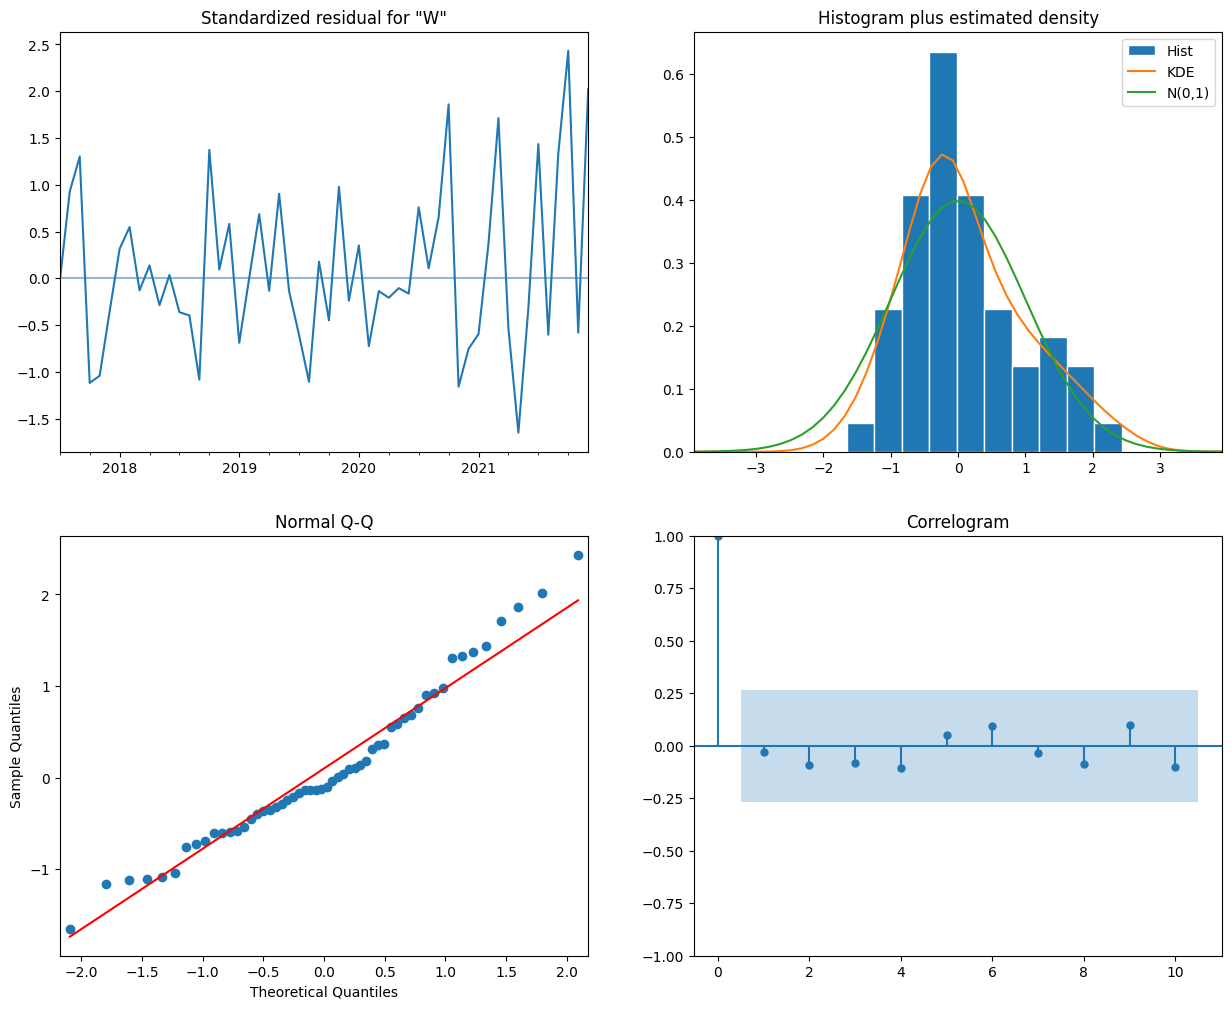

In [ ]:
# plot residual diagnostics
model_heuristic.plot_diagnostics(figsize=(15,12));

In [ ]:
# forecast for heuristic model
df_train['arima_model'] = [x if x > 0 else 0 for x in model_heuristic.fittedvalues]
forecast_heuristic = model_heuristic.predict(start=pd.to_datetime("2022-01-01"), end=pd.to_datetime("2022-12-01"))
forecast_heuristic = df_train['arima_model'].append(forecast_heuristic)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast_heuristic, color='r', label='model')
plt.axvspan(df_test.index[0], forecast_heuristic.index[-1], alpha=0.5, color='lightgrey')
plt.plot(df['WON_REVENUE'], label='actual')
plt.grid(axis='y')
plt.xlabel('DATE', fontsize=20)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.legend()
plt.show()

In [ ]:
print('MSE for heuristic model:',mean_squared_error(df_test['WON_REVENUE'], forecast_heuristic[-12:]))
print('Explained variance for heuristic model:',explained_variance_score(df_test['WON_REVENUE'], forecast_heuristic[-12:]))

##### Optimized
In the optimization approach, instead of only searching for the best model within the given differencing order, I looped through all possible combinations of (p,d,q)x(P,D,Q). Further, a validation split of 12 periods was introduced to the train set to optimize for the validation loss.

In [ ]:
# split data again to retrieve validation split
df_train = df.iloc[:-24]
df_val = df.iloc[-24:-12]

In [ ]:
# zero differencing grid search (optimization approach)
result_df = optimize_SARIMA(parameters_list, 0, 0, 12, df_train['WON_REVENUE'], df_val['WON_REVENUE'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",val loss
0,"(3, 3, 0, 0)",1.012377e+10
1,"(1, 1, 0, 0)",1.017319e+10
2,"(2, 3, 0, 0)",1.017351e+10
3,"(2, 1, 0, 0)",1.024194e+10
4,"(1, 3, 0, 0)",1.031502e+10
...,...,...
251,"(1, 0, 1, 0)",1.177039e+10
252,"(2, 0, 1, 1)",1.177308e+10
253,"(2, 0, 1, 0)",1.177913e+10
254,"(3, 0, 1, 0)",1.178509e+10


In [ ]:
# d = 1; D = 0 grid search (optimization approach)
result_df = optimize_SARIMA(parameters_list, 1, 0, 12, df_train['WON_REVENUE'], df_val['WON_REVENUE'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",val loss
0,"(3, 0, 0, 0)",8.462181e+09
1,"(2, 0, 0, 0)",8.540072e+09
2,"(0, 0, 0, 0)",8.768899e+09
3,"(3, 0, 1, 0)",9.148599e+09
4,"(2, 0, 1, 0)",9.156748e+09
...,...,...
251,"(3, 1, 2, 3)",1.074053e+10
252,"(3, 1, 3, 3)",1.074202e+10
253,"(3, 1, 1, 0)",1.075647e+10
254,"(0, 2, 1, 0)",1.104126e+10


In [ ]:
# d = 2; D = 0 grid search (optimization approach)
result_df = optimize_SARIMA(parameters_list, 2, 0, 12, df_train['WON_REVENUE'], df_val['WON_REVENUE'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",val loss
0,"(3, 1, 0, 0)",7.874832e+09
1,"(3, 2, 0, 0)",7.941633e+09
2,"(2, 1, 0, 0)",8.003794e+09
3,"(2, 1, 1, 1)",8.093544e+09
4,"(3, 1, 1, 0)",8.309101e+09
...,...,...
251,"(1, 0, 2, 0)",8.917792e+10
252,"(1, 0, 1, 2)",8.926930e+10
253,"(1, 0, 0, 2)",8.988171e+10
254,"(1, 0, 2, 1)",8.990385e+10


In [ ]:
# d = 0; D = 1
result_df = optimize_SARIMA(parameters_list, 0, 1, 12, df_train['WON_REVENUE'], df_val['WON_REVENUE'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",val loss
0,"(3, 2, 0, 0)",6.908176e+09
1,"(2, 2, 0, 0)",6.912062e+09
2,"(1, 1, 0, 0)",6.937082e+09
3,"(0, 3, 0, 0)",6.939822e+09
4,"(2, 0, 0, 0)",6.942040e+09
...,...,...
251,"(1, 3, 3, 2)",1.014596e+10
252,"(0, 0, 3, 0)",1.077595e+10
253,"(0, 0, 1, 1)",1.080185e+10
254,"(0, 0, 2, 1)",1.083967e+10


In [ ]:
# d = 1; D = 1 grid search (optimization approach)
result_df = optimize_SARIMA(parameters_list, 1, 1, 12, df_train['WON_REVENUE'], df_val['WON_REVENUE'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",val loss
0,"(3, 0, 0, 0)",5.540437e+09
1,"(2, 0, 0, 0)",5.692454e+09
2,"(0, 0, 0, 0)",6.151587e+09
3,"(3, 2, 0, 0)",6.432934e+09
4,"(1, 2, 0, 0)",6.585668e+09
...,...,...
250,"(3, 3, 2, 2)",9.276787e+09
251,"(3, 3, 2, 3)",9.277238e+09
252,"(3, 3, 3, 1)",9.277715e+09
253,"(3, 3, 3, 2)",9.278615e+09


In [ ]:
# d = 2; D = 1 grid search (optimization approach)
result_df = optimize_SARIMA(parameters_list, 2, 1, 12, df_train['WON_REVENUE'], df_val['WON_REVENUE'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",val loss
0,"(0, 0, 1, 0)",5.255072e+09
1,"(3, 1, 0, 0)",5.284069e+09
2,"(3, 2, 0, 0)",5.304144e+09
3,"(0, 0, 2, 2)",5.330736e+09
4,"(0, 0, 2, 0)",5.346619e+09
...,...,...
251,"(1, 0, 3, 0)",1.007299e+11
252,"(1, 0, 0, 3)",1.007726e+11
253,"(1, 0, 0, 2)",1.031602e+11
254,"(1, 0, 0, 1)",1.114475e+11


In [ ]:
# remove validation split so that train set covers full training data again
df_train = df.iloc[:-12]

In [ ]:
# train optimized model (0, 2, 0)x(1, 1, 0, 12)
model_optimal = SARIMAX(df_train['WON_REVENUE'], order=(0, 2, 0), seasonal_order=(1, 1, 0, 12)).fit(dis=-1)

In [ ]:
# print model summary
model_optimal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        WON_REVENUE   No. Observations:                   67
Model:             SARIMAX(0, 2, 0)x(1, 1, 0, 12)   Log Likelihood                -678.163
Date:                            Sat, 22 Apr 2023   AIC                           1360.327
Time:                                    12:24:02   BIC                           1364.267
Sample:                                06-01-2016   HQIC                          1361.842
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.5078      0.127     -4.004      0.000      -0.756      -0.259
sigma2      8.732e+09   7.67e-12   1.14e+21      0.000    8.73e+09    8.73e+09
===================================================================================
Ljung-Box (L1) (Q):                  19.14   Jarque-Bera (JB):                15.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.86   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

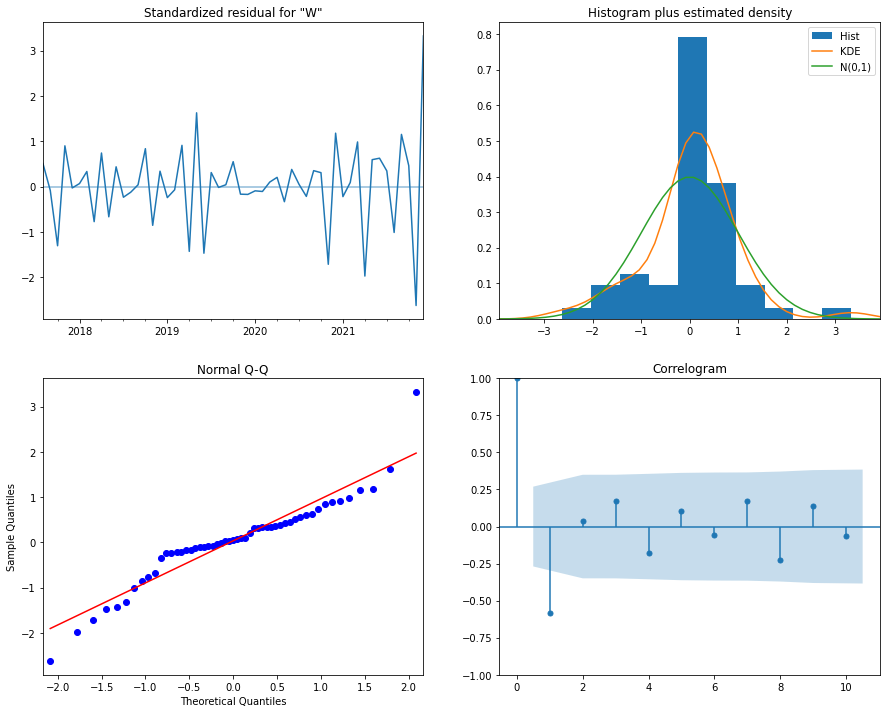

In [ ]:
# plot residuals diagnostics
model_optimal.plot_diagnostics(figsize=(15,12));

In [ ]:
# forecast for optimal model
df_train['arima_model'] = [x if x > 0 else 0 for x in model_optimal.fittedvalues]
forecast_optimal = model_optimal.predict(start=pd.to_datetime("2022-01-01"), end=pd.to_datetime("2022-12-01"))
forecast_optimal = df_train['arima_model'].append(forecast_optimal)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast_optimal, color='r', label='model')
plt.axvspan(df_train.index[-1], forecast_optimal.index[-1], alpha=0.5, color='lightgrey')
plt.plot(df['WON_REVENUE'], label='actual')
plt.grid(axis='y')
plt.xlabel('DATE', fontsize=20)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.legend()
plt.show()

In [ ]:
print('RMSE for optimal model:',math.sqrt(mean_squared_error(df_test['WON_REVENUE'], forecast_optimal[-12:])))
print('Explained variance for optimal model:',explained_variance_score(df_test['WON_REVENUE'], forecast_optimal[-12:]))

RMSE for optimal model: 1458273.3001145269
Explained variance for optimal model: -18.659465148603882


#### 2 years window
For the 2 years series, I only pursued a heuristics approach due to the reduced number of data points. Thus, based on the results from the EDA, we conduct a grid search on the series after applying non-seasonal and seasonal differencing, optimizing for the achieved AICc.

In [ ]:
# shorten dataset to only retain most recent three years (2 years of training data + 1 year of test data)
df_shortened = df[-36:]

In [ ]:
# split data
df_train = df_shortened.iloc[:-12]
df_test = df_shortened.iloc[-12:]

In [ ]:
# plot 2-year train series
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(df_train)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.xlabel('DATE', fontsize=20)
plt.grid(axis='y')
plt.show()

In [ ]:
# d = 1; D = 1
result_df = optimize_SARIMA(parameters_list, 1, 1, 12, df_train['WON_REVENUE'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AICc
0,"(0, 0, 2, 1)",1.466667e+01
1,"(2, 2, 3, 3)",2.582220e+01
2,"(3, 1, 3, 3)",2.924284e+01
3,"(2, 2, 0, 3)",8.800000e+01
4,"(2, 2, 1, 2)",8.800000e+01
...,...,...
172,"(3, 2, 1, 1)",4.302656e+15
173,"(0, 3, 0, 0)",NaN
174,"(0, 3, 0, 1)",NaN
175,"(0, 3, 0, 2)",NaN


In [ ]:
# train heuristics model (1, 0, 0)x(0, 0, 0, 12)
model_heuristic = SARIMAX(df_train['WON_REVENUE'], order=(1, 0, 0), seasonal_order=(0, 0, 0, 12)).fit(dis=-1)

In [ ]:
# print model summary
model_heuristic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            WON_REVENUE   No. Observations:                   24
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -302.901
Date:                Mon, 24 Apr 2023   AIC                            609.802
Time:                        18:59:09   BIC                            612.158
Sample:                    01-01-2020   HQIC                           610.427
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4643      0.218      2.130      0.033       0.037       0.892
sigma2      5.536e+09    3.2e-11   1.73e+20      0.000    5.54e+09    5.54e+09
===================================================================================
Ljung-Box (L1) (Q):                   2.04   Jarque-Bera (JB):                11.89
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):                inf   Skew:                             1.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

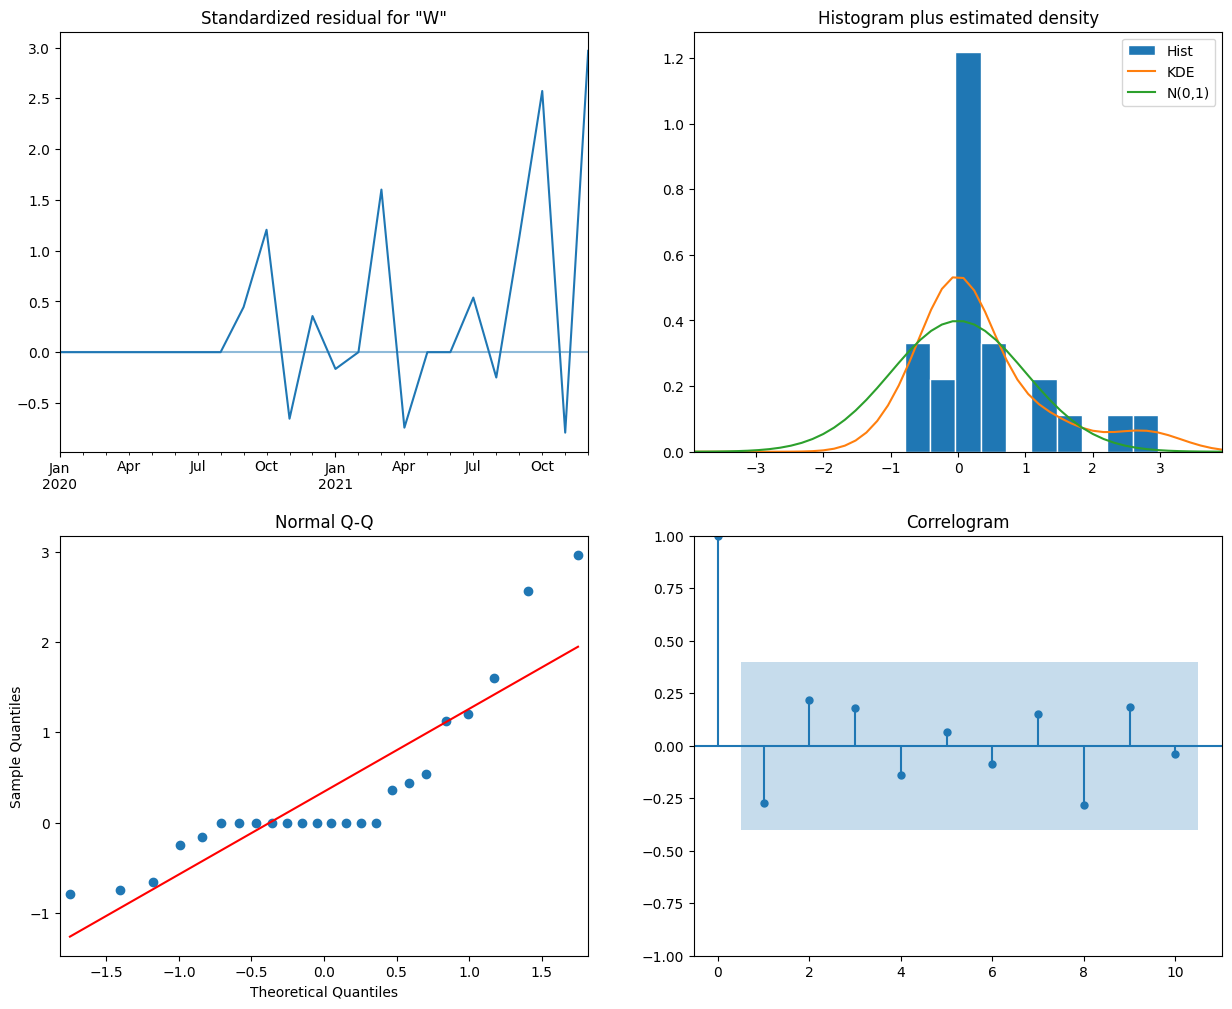

In [ ]:
# plot residual diagnostics
model_heuristic.plot_diagnostics(figsize=(15,12));

In [ ]:
# forecast for heuristic model
df_train['arima_model'] = [x if x > 0 else 0 for x in model_heuristic.fittedvalues]
forecast_heuristic = model_heuristic.predict(start=pd.to_datetime("2022-01-01"), end=pd.to_datetime("2022-12-01"))
forecast_heuristic = df_train['arima_model'].append(forecast_heuristic)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast_heuristic, color='r', label='model')
plt.axvspan(df_test.index[0], forecast_heuristic.index[-1], alpha=0.5, color='lightgrey')
plt.plot(df_shortened['WON_REVENUE'], label='actual')
plt.grid(axis='y')
plt.xlabel('DATE', fontsize=20)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.legend()
plt.show()

In [ ]:
print('RMSE for heuristic model:',math.sqrt(mean_squared_error(df_test['WON_REVENUE'], forecast_heuristic[-12:])))
print('Explained variance for heuristic model:',explained_variance_score(df_test['WON_REVENUE'], forecast_heuristic[-12:]))

RMSE for heuristic model: 183188.0153727963
Explained variance for heuristic model: -0.05439006247846656


### Neural-Prophet

In [ ]:
# clone NeuralProphet git repository
#!git clone https://github.com/ourownstory/neural_prophet.git

Cloning into 'neural_prophet'...
remote: Enumerating objects: 9204, done.
remote: Counting objects: 100% (644/644), done.
remote: Compressing objects: 100% (320/320), done.
remote: Total 9204 (delta 443), reused 476 (delta 317), pack-reused 8560
Receiving objects: 100% (9204/9204), 190.61 MiB | 9.56 MiB/s, done.
Resolving deltas: 100% (6333/6333), done.


In [ ]:
cd neural_prophet

In [ ]:
# install NeuralProphet repository
pip install .[live]

In [ ]:
# import NeuralProphet functionality
from neuralprophet import NeuralProphet

In [ ]:
# ensuring reproducibility of results
from neuralprophet import set_random_seed 

In [ ]:
# adjust data format to NP requirements
df = df.reset_index()
df.columns = ['ds','y']
df

#### Full series
On the full series data, both a heuristics as well as an optimization approach were pursued.

In [ ]:
# split data
df_train = df[:-12]
df_test = df[-12:]

In [ ]:
# create enlarged train series for prediction generation
enlarged_df = df_train.append(pd.DataFrame({'ds':[pd.Timestamp('2022-01-01'),pd.Timestamp('2022-02-01'),pd.Timestamp('2022-03-01'),pd.Timestamp('2022-04-01'),pd.Timestamp('2022-05-01'),pd.Timestamp('2022-06-01'),pd.Timestamp('2022-07-01'),pd.Timestamp('2022-08-01'),pd.Timestamp('2022-09-01'),pd.Timestamp('2022-10-01'),pd.Timestamp('2022-11-01'),pd.Timestamp('2022-12-01')],'y':[np.nan for i in range(12)]}))
enlarged_df.tail(13)

##### Heuristic
For the heuristics approach n_forecasts was set to be equal to the forecasting horizon (12 periods), n_lags twice the forecasting horizon (24 periods), num_hidden_layers to 0 and the loss_func set to the MSE.

In [ ]:
# initialize and train heuristics model
set_random_seed(0)
NP = NeuralProphet(growth='linear',
                   changepoints=None,
                   n_changepoints=10,
                   changepoints_range=0.8,
                   trend_reg=0, 
                   trend_reg_threshold=False, 
                   trend_global_local='global', 
                   yearly_seasonality='auto', 
                   weekly_seasonality='auto', 
                   daily_seasonality='auto', 
                   seasonality_mode='additive', 
                   seasonality_reg=0, 
                   season_global_local='global', 
                   n_forecasts=12, 
                   n_lags=24, 
                   num_hidden_layers=0, 
                   d_hidden=None, 
                   ar_reg=None, 
                   learning_rate=None, 
                   epochs=None, 
                   batch_size=None, 
                   loss_func='MSE',
                   optimizer='AdamW', 
                   newer_samples_weight=2, 
                   newer_samples_start=0.0, 
                   quantiles=None, 
                   impute_missing=True, 
                   impute_linear=10, 
                   impute_rolling=10, 
                   drop_missing=False, 
                   collect_metrics=True, 
                   normalize='auto', 
                   global_normalization=False, 
                   global_time_normalization=True, 
                   unknown_data_normalization=False)
train_metrics = NP.fit(df_train)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.507]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 1000
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (2) is too small than the required number for the learning rate finder (205). The result

Finding best initial lr:   0%|          | 0/205 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
# generate prediction
predicted = NP.predict(enlarged_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.734]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.734]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 2it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [ ]:
# clip values below 0
predicted['yhat12'] = [x if (x!=x or x >= 0) else 0 for x in predicted['yhat12']]

In [ ]:
# plot heuristics forecast
plt.figure(figsize=(15, 7.5))
plt.plot(predicted.set_index('ds')['yhat12'], color='r', label='model')
plt.axvspan(predicted.set_index('ds').index[-12], predicted.set_index('ds').index[-1], alpha=0.5, color='lightgrey')
plt.plot(df.set_index("ds"), label='actual')
plt.grid(axis='y')
plt.xlabel('DATE', fontsize=20)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.legend()
plt.show()

In [ ]:
# plot NP parameters
NP.plot_parameters()

In [ ]:
print('RMSE:',math.sqrt(mean_squared_error(df_test['y'], predicted['yhat12'][-12:])))
print('Explained variance:',explained_variance_score(df_test['y'], predicted['yhat12'][-12:]))

RMSE: 256510.82674335263
Explained variance: -1.604042749110377


##### Optimized
For the optimization approach, n_forecasts was again set to be equal to the forecasting horizon (12 periods) and the loss_func to be the MSE, but this time, n_lags was varied in the range from 0 to 24 and num_hidden_layers was varied within the range from 0 to 2. Further, a validation split of 12 periods was introduced to the train set to optimize for the validation loss.

In [ ]:
# initialize lists to store configurations along with the respective train, validation and test loss
'''configs = []
test_losses = []
train_losses = []
val_losses = []'''

In [ ]:
# Grid search for p=0
'''l = 0
p = 0
set_random_seed(0)
NP = NeuralProphet(growth='linear',
                      n_lags=p, 
                      n_forecasts=12,
                      num_hidden_layers=l, 
                      d_hidden=None,
                      loss_func='MSE')
train,val = NP.split_df(df_train,valid_p=1)
train_metrics = NP.fit(train)
val_metrics = NP.test(val)
configs.append((l,p))
predicted = NP.predict(enlarged_df)

test_losses.append(mean_squared_error(df_test['y'], NP.predict(enlarged_df)['yhat1'][-12:]))
train_losses.append(train_metrics.iloc[-1,2])
val_losses.append(val_metrics.iloc[0,0])'''

In [ ]:
# Grid search for p>0 (value of p must be adjusted)
'''p = 1
for l in range(0,3):
  set_random_seed(0)
  NP = NeuralProphet(growth='linear',
                        n_lags=p, 
                        n_forecasts=12,
                        num_hidden_layers=l, 
                        d_hidden=None,
                        loss_func='MSE')
  train,val = NP.split_df(df_train,valid_p=1)
  train_metrics = NP.fit(train)
  val_metrics = NP.test(val)
  configs.append((l,p))
  predicted = NP.predict(enlarged_df)

  test_losses.append(mean_squared_error(df_test['y'], NP.predict(enlarged_df)['yhat12'][-12:]))
  train_losses.append(train_metrics.iloc[-1,2])
  val_losses.append(val_metrics.iloc[0,0])'''

In [ ]:
# sorted results from hyperparameter tuning
results = pd.DataFrame({'config':configs,'test loss':test_losses, 'val loss':val_losses, 'train loss':train_losses})
results.sort_values('val loss')

,config,test loss,val loss,train loss
1,"(0, 1)",2.225251e+10,1.477959,5.272799e-02
7,"(0, 3)",2.345859e+10,1.608313,5.141672e-02
17,"(1, 6)",2.450058e+10,1.802285,5.883272e-02
0,"(0, 0)",2.466625e+10,1.833580,6.797793e-02
4,"(0, 2)",2.509288e+10,1.838009,5.486361e-02
2,"(1, 1)",2.838015e+10,1.845718,5.722590e-02
12,"(2, 4)",2.502931e+10,1.854778,5.351451e-02
8,"(1, 3)",2.511086e+10,1.860996,5.686995e-02
3,"(2, 1)",3.214323e+10,1.866277,5.659177e-02
44,"(1, 16)",3.283051e+10,1.920479,2.893122e-02


In [ ]:
# initialize and train optimal model with n_lags=1 and num_hidden_layers=0
set_random_seed(0)
NP = NeuralProphet(growth='linear',
                   changepoints=None,
                   n_changepoints=10,
                   changepoints_range=0.8,
                   trend_reg=0, 
                   trend_reg_threshold=False, 
                   trend_global_local='global', 
                   yearly_seasonality='auto', 
                   weekly_seasonality='auto', 
                   daily_seasonality='auto', 
                   seasonality_mode='additive', 
                   seasonality_reg=0, 
                   season_global_local='global', 
                   n_forecasts=12, 
                   n_lags=1, 
                   num_hidden_layers=0, 
                   d_hidden=None, 
                   ar_reg=None, 
                   learning_rate=None, 
                   epochs=None, 
                   batch_size=None, 
                   loss_func='MSE', #quantile loss?
                   optimizer='AdamW', 
                   newer_samples_weight=2, 
                   newer_samples_start=0.0, 
                   quantiles=None, 
                   impute_missing=True, 
                   impute_linear=10, 
                   impute_rolling=10, 
                   drop_missing=False, 
                   collect_metrics=True, 
                   normalize='auto', 
                   global_normalization=False, 
                   global_time_normalization=True, 
                   unknown_data_normalization=False)
train_metrics = NP.fit(df_train)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.507]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 809
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (4) is too small than the required number for the learning rate finder (205). The results

Finding best initial lr:   0%|          | 0/205 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
# generate prediction
predicted = NP.predict(enlarged_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.734]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.734]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 4it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [ ]:
# clip values below 0
predicted['yhat12'] = [x if (x!=x or x >= 0) else 0 for x in predicted['yhat12']]

In [ ]:
# plot optimized forecast
plt.figure(figsize=(15, 7.5))
plt.plot(predicted.set_index('ds')['yhat12'], color='r', label='model')
plt.axvspan(predicted.set_index('ds').index[-12], predicted.set_index('ds').index[-1], alpha=0.5, color='lightgrey')
plt.plot(df.set_index("ds"), label='actual')
plt.grid(axis='y')
plt.xlabel('DATE', fontsize=20)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.legend()
plt.show()

In [ ]:
# plot NP parameters
NP.plot_parameters(predicted)

In [ ]:
print('RMSE:',math.sqrt(mean_squared_error(df_test['y'], predicted['yhat12'][-12:])))
print('Explained variance:',explained_variance_score(df_test['y'], predicted['yhat12'][-12:]))

RMSE: 164777.95092580348
Explained variance: -0.17224630539891717


#### 2 years window
For the 2 years window, only the heuristics approach was pursued. Thus, n_forecasts was set to be equal to the forecasting horizon (12 periods), num_hidden_layers to 0 and the loss_func set to the MSE. Due to the shortened length of the series n_lags could only be set to a maximum of 12.

In [ ]:
# shorten dataset to only retain most recent three years (2 years of training data + 1 year of test data)
df = df[df['ds']>=pd.Timestamp("2020-01-01")]

In [ ]:
# split data
df_train = df[:-12]
df_test = df[-12:]

In [ ]:
# create enlarged train series for prediction generation
enlarged_df = df_train.append(pd.DataFrame({'ds':[pd.Timestamp('2022-01-01'),pd.Timestamp('2022-02-01'),pd.Timestamp('2022-03-01'),pd.Timestamp('2022-04-01'),pd.Timestamp('2022-05-01'),pd.Timestamp('2022-06-01'),pd.Timestamp('2022-07-01'),pd.Timestamp('2022-08-01'),pd.Timestamp('2022-09-01'),pd.Timestamp('2022-10-01'),pd.Timestamp('2022-11-01'),pd.Timestamp('2022-12-01')],'y':[np.nan for i in range(12)]}))
enlarged_df.tail(13)

In [ ]:
# train heuristics model
set_random_seed(0)
NP = NeuralProphet(growth='linear',
                   changepoints=None,
                   n_changepoints=10,
                   changepoints_range=0.8,
                   trend_reg=0, 
                   trend_reg_threshold=False, 
                   trend_global_local='global', 
                   yearly_seasonality='auto', 
                   weekly_seasonality='auto', 
                   daily_seasonality='auto', 
                   seasonality_mode='additive', 
                   seasonality_reg=0, 
                   season_global_local='global', 
                   n_forecasts=12, 
                   n_lags=12, 
                   num_hidden_layers=0, 
                   d_hidden=None, 
                   ar_reg=None, 
                   learning_rate=None, 
                   epochs=None, 
                   batch_size=None, 
                   loss_func='MSE', #quantile loss?
                   optimizer='AdamW', 
                   newer_samples_weight=2, 
                   newer_samples_start=0.0, 
                   quantiles=None, 
                   impute_missing=True, 
                   impute_linear=10, 
                   impute_rolling=10, 
                   drop_missing=False, 
                   collect_metrics=True, 
                   normalize='auto', 
                   global_normalization=False, 
                   global_time_normalization=True, 
                   unknown_data_normalization=False)

In [ ]:
# train model
train_metrics = NP.fit(df_train)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 1
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 1000
WARNING - (NP.config.set_lr_finder_arg

Finding best initial lr:   0%|          | 0/202 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
# generate prediction
predicted = NP.predict(enlarged_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [97.222]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [97.222]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 1it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [ ]:
# plot heuristics forecasts
plt.figure(figsize=(15, 7.5))
plt.plot(predicted.set_index('ds')['yhat12'], color='r', label='model')
plt.axvspan(predicted.set_index('ds').index[-12], predicted.set_index('ds').index[-1], alpha=0.5, color='lightgrey')
plt.plot(df.set_index("ds"), label='actual')
plt.grid(axis='y')
plt.xlabel('DATE', fontsize=20)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.legend()
plt.show()

In [ ]:
# plot NP parameters
NP.plot_parameters()

In [ ]:
print('RMSE:',math.sqrt(mean_squared_error(df_test['y'], predicted['yhat12'][-12:])))
print('Explained variance:',explained_variance_score(df_test['y'], predicted['yhat12'][-12:]))

RMSE: 287062.5816433995
Explained variance: -0.9168443461807583


### Temporal Fusion Transformer

In [ ]:
# library installation for TFT
pip install darts

In [ ]:
# TFT-specific imports
from darts.models.forecasting.tft_model import TFTModel
from darts.timeseries import TimeSeries as ts
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from tqdm import tqdm_notebook
from darts.metrics import mape

#### Full series

In [ ]:
# adjust data format to TFT requirements
tsdata = ts.from_dataframe(df)

In [ ]:
# split data
train, test = tsdata.split_after(pd.Timestamp("2021-12-01"))

In [ ]:
# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(tsdata, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(tsdata, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    ts.from_times_and_values(
        times=tsdata.time_index,
        values=np.arange(len(tsdata)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)
covariates

In [ ]:
# set up TFT model using the default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
tft = TFTModel(
    input_chunk_length=24,
    output_chunk_length=12,
    hidden_size=16,
    lstm_layers=1,
    num_attention_heads=4, 
    full_attention=False, 
    feed_forward='GatedResidualNetwork', 
    dropout=0.1,
    hidden_continuous_size=8, 
    categorical_embedding_sizes=None, 
    add_relative_index=False, 
    loss_fn=None,
    likelihood=QuantileRegression(quantiles=quantiles), 
    norm_type='LayerNorm',
    n_epochs=1000)

In [ ]:
# train heuristic model
fit = tft.fit(train,verbose=True,future_covariates=covariates)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 13.1 K
5  | decoder_vsn                       | _Vari

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.


In [ ]:
# retrieve quantile forecast from collecting 1825 samples
predictions = tft.predict(12,future_covariates=covariates,num_samples=1825)
predictions.plot()

In [ ]:
# retrieve point forecast from collecting 1 sample
predictions = tft.predict(12,future_covariates=covariates,num_samples=1)
predictions.plot()

In [ ]:
# plot heuristics forecast
forecast = predictions.pd_dataframe().mean(axis=1)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(forecast.index[0], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(tsdata.pd_dataframe()['WON_REVENUE'], label='actual')
plt.legend()
plt.show()

In [ ]:
print('MSE:',mean_squared_error(test.pd_dataframe()['WON_REVENUE'], predictions.pd_dataframe().mean(axis=1)))
print('Explained variance:',explained_variance_score(test.pd_dataframe()['WON_REVENUE'], predictions.pd_dataframe().mean(axis=1)))

MSE: 35933778632.77113
Explained variance: -0.0005778742916089374


In [ ]:
# additional experiment with very high number of epochs
tft = TFTModel(
    input_chunk_length=24,
    output_chunk_length=12,
    hidden_size=128,
    lstm_layers=1,
    num_attention_heads=4, 
    full_attention=False, 
    feed_forward='GatedResidualNetwork', 
    dropout=0.1,
    hidden_continuous_size=8, 
    categorical_embedding_sizes=None, 
    add_relative_index=False, 
    loss_fn=None,
    likelihood=QuantileRegression(quantiles=quantiles), 
    norm_type='LayerNorm',
    n_epochs=10000)

In [ ]:
# train model
fit = tft.fit(train,verbose=True,future_covariates=covariates)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 13.1 K
5  | decoder_vsn                       | _Vari

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10000` reached.


In [ ]:
#tft.save('C6_full_series_10000_epochs.pt')

In [ ]:
#tft = TFTModel.load('C6_full_series_10000_epochs.pt')

In [ ]:
# retrieve quantile forecast from collecting 1825 samples
predictions = tft.predict(12,future_covariates=covariates,num_samples=1825)
predictions.plot()

In [ ]:
# retrieve point forecast from collecting 1 sample
predictions = tft.predict(12,future_covariates=covariates,num_samples=1)
predictions.plot()

In [ ]:
# plot forecast
forecast = predictions.pd_dataframe().mean(axis=1)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(forecast.index[0], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(tsdata.pd_dataframe()['WON_REVENUE'], label='actual')
plt.grid(axis='y')
plt.legend()
plt.xlabel('DATE', fontsize=20)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.show()

In [ ]:
print('MSE:',mean_squared_error(test.pd_dataframe()['WON_REVENUE'], predictions.pd_dataframe().mean(axis=1)))
print('Explained variance:',explained_variance_score(test.pd_dataframe()['WON_REVENUE'], predictions.pd_dataframe().mean(axis=1)))

MSE: 32462696357.260075
Explained variance: 0.0717019833916942


#### 2 years window

In [ ]:
# shorten dataset to only retain most recent three years (2 years of training data + 1 year of test data)
tsdata = ts.from_dataframe(df).drop_before(pd.to_datetime("2019-12-01"))

In [ ]:
# split data
train, test = tsdata.split_after(pd.Timestamp("2021-12-01"))

In [ ]:
# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(tsdata, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(tsdata, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    ts.from_times_and_values(
        times=tsdata.time_index,
        values=np.arange(len(tsdata)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)
covariates

In [ ]:
# set up model with increased hidden_size and n_epochs
tft = TFTModel(
    input_chunk_length=12,
    output_chunk_length=12,
    hidden_size=124,
    lstm_layers=1,
    num_attention_heads=4, 
    full_attention=False, 
    feed_forward='GatedResidualNetwork', 
    dropout=0.1,
    hidden_continuous_size=8, 
    categorical_embedding_sizes=None, 
    add_relative_index=False, 
    loss_fn=None,
    likelihood=QuantileRegression(quantiles=quantiles), 
    norm_type='LayerNorm',
    n_epochs=1000)

In [ ]:
# train model
fit = tft.fit(train,verbose=True,future_covariates=covariates)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 50.0 K
5  | decoder_vsn                       | _Vari

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.


In [ ]:
# retrieve quantile forecast from collecting 1825 samples
predictions = tft.predict(12,future_covariates=covariates,num_samples=1825)
predictions.plot()

In [ ]:
# retrieve point forecast from collecting 1 sample
predictions = tft.predict(12,future_covariates=covariates,num_samples=1)
predictions.plot()

In [ ]:
# forecast for model
forecast = predictions.pd_dataframe().mean(axis=1)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(forecast.index[0], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(tsdata.pd_dataframe()['WON_REVENUE'], label='actual')
plt.grid(axis='y')
plt.xlabel('DATE', fontsize=20)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.legend()
plt.show()

In [ ]:
print('RMSE:',math.sqrt(mean_squared_error(test.pd_dataframe()['WON_REVENUE'], predictions.pd_dataframe().mean(axis=1))))
print('Explained variance:',explained_variance_score(test.pd_dataframe()['WON_REVENUE'], predictions.pd_dataframe().mean(axis=1)))

RMSE: 188775.96052103105
Explained variance: 0.0038046164239384783


## Group 3 - prototype dataset C4

C1 is characterized by being the shortest dataset, including medium volatility and regularity.

Due to the short length, experimentation was not split into full series and 2 years data approach. Further, for the same reason, only a heuristics approach could be pursued.

In [ ]:
# load Sales model data from Google Sheets
worksheet = gc.open('C1').sheet1
rows = worksheet.get_all_values()

# convert to dataframe
df = pd.DataFrame.from_records(rows[1:],columns=rows[0])
df['VALUE'] = pd.to_numeric(df['VALUE'])
df['DATE'] = pd.to_datetime(df['DATE'])
df.head()

In [ ]:
# Group and pivot data
df = pd.DataFrame(df.groupby(['DATE','METRIC'])['VALUE'].sum()).reset_index()
df = df.pivot(index=['DATE'],columns=['METRIC'],values=['VALUE'])
df.columns = [col[1] for col in df.columns]

# filter DataFrame to only keep data WON_REVENUE
df = df[['WON_REVENUE']].dropna()
df.head()

### ARIMA

In [ ]:
# SARIMAX-specific imports
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        try: 
            aicc = model.aicc
        except:
            aicc = -1
        results.append([param, aicc])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AICc']
    #Sort by AIC in ascending order, lower is better in both cases
    result_df = result_df.sort_values(by='AICc', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
p = range(0, 4, 1)
q = range(0, 4, 1)
P = range(0, 4, 1)
Q = range(0, 4, 1)
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
# split data
df_train = df.iloc[:-12]
df_test = df.iloc[-12:]

In [ ]:
# plot full series
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(df_train)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.xlabel('DATE', fontsize=20)
plt.grid(axis='y')
plt.show()

In [ ]:
# d = 2; D = 0 grid search (heuristics approach)
result_df = optimize_SARIMA(parameters_list, 2, 0, 12, df_train['WON_REVENUE'])
result_df[result_df['AICc']>=100]

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AICc
45,"(3, 1, 3, 3)",1.197024e+02
46,"(2, 3, 3, 2)",1.259573e+02
47,"(2, 3, 2, 3)",1.259573e+02
48,"(3, 3, 3, 1)",1.259980e+02
49,"(3, 3, 1, 3)",1.259980e+02
...,...,...
242,"(3, 2, 2, 2)",5.917015e+13
243,"(3, 2, 2, 3)",5.917015e+13
244,"(3, 2, 3, 3)",5.917015e+13
245,"(3, 2, 1, 0)",5.917018e+13


In [ ]:
# train heuristics model (3, 2, 1)x(3, 0, 3, 12)
model_heuristic = SARIMAX(df_train['WON_REVENUE'], order=(3, 2, 1), seasonal_order=(3, 0, 3, 12)).fit(dis=-1)

In [ ]:
# print model summary
model_heuristic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                WON_REVENUE   No. Observations:                   12
Model:             SARIMAX(3, 2, 1)x(3, 0, [1, 2, 3], 12)   Log Likelihood                -114.851
Date:                                    Wed, 26 Apr 2023   AIC                            251.702
Time:                                            15:22:45   BIC                            255.031
Sample:                                        01-01-2021   HQIC                           248.051
                                             - 12-01-2021                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8108      9.193     -0.088      0.930     -18.829      17.207
ar.L2         -0.3426     15.047     -0.023      0.982     -29.835      29.150
ar.L3          0.2817     14.746      0.019      0.985     -28.620      29.184
ma.L1         -0.7808     16.055     -0.049      0.961     -32.248      30.687
ar.S.L12      -0.0176   8.81e+05     -2e-08      1.000   -1.73e+06    1.73e+06
ar.S.L24       0.0061    2.3e+06   2.66e-09      1.000   -4.51e+06    4.51e+06
ar.S.L36      -0.0001   2.83e+05  -4.02e-10      1.000   -5.54e+05    5.54e+05
ma.S.L12      -0.0182   8.81e+05  -2.06e-08      1.000   -1.73e+06    1.73e+06
ma.S.L24      -0.0046   2.27e+06     -2e-09      1.000   -4.45e+06    4.45e+06
ma.S.L36       0.0015   2.18e+05   6.67e-09      1.000   -4.27e+05    4.27e+05
sigma2      8.667e+08     10.778   8.04e+07      0.000    8.67e+08    8.67e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.58
Prob(Q):                              0.97   Prob(JB):                         0.75
Heteroskedasticity (H):              18.51   Skew:                             0.37
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.68e+26. Standard errors may be unstable.
"""

ValueError: ignored

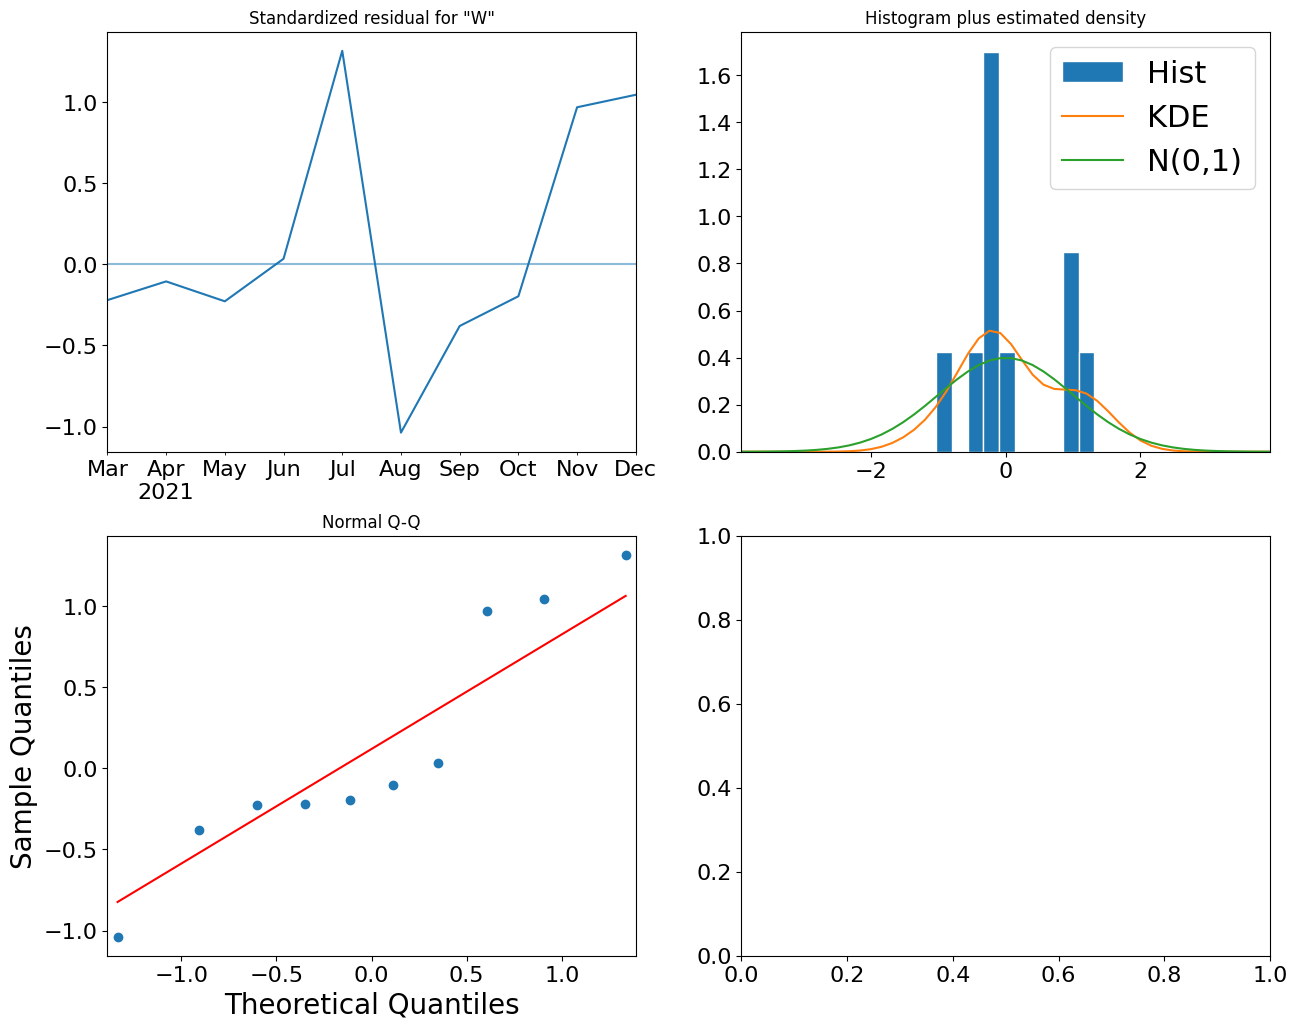

In [ ]:
# plot residual diagnostics
model_heuristic.plot_diagnostics(figsize=(15,12));

In [ ]:
# forecast for heuristic model (3, 2, 1)x(3, 0, 3, 12)
df_train['arima_model'] = [x if x > 0 else 0 for x in model_heuristic.fittedvalues]
forecast_heuristic = model_heuristic.predict(start=pd.to_datetime("2022-01-01"), end=pd.to_datetime("2022-12-01"))
forecast_heuristic = df_train['arima_model'].append(forecast_heuristic)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast_heuristic, color='r', label='model')
plt.axvspan(df_test.index[0], forecast_heuristic.index[-1], alpha=0.5, color='lightgrey')
plt.plot(df['WON_REVENUE'], label='actual')
plt.grid(axis='y')
plt.xlabel('DATE', fontsize=20)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.legend()
plt.show()

In [ ]:
print('RMSE for heuristic model:',math.sqrt(mean_squared_error(df_test['WON_REVENUE'], forecast_heuristic[-12:])))
print('Explained variance for heuristic model:',explained_variance_score(df_test['WON_REVENUE'], forecast_heuristic[-12:]))

RMSE for heuristic model: 85008.15888469611
Explained variance for heuristic model: -0.11872205609171615


### Neural-Prophet

In [ ]:
# clone NeuralProphet git repository
#!git clone https://github.com/ourownstory/neural_prophet.git

Cloning into 'neural_prophet'...
remote: Enumerating objects: 9199, done.
remote: Counting objects: 100% (639/639), done.
remote: Compressing objects: 100% (328/328), done.
remote: Total 9199 (delta 441), reused 463 (delta 304), pack-reused 8560
Receiving objects: 100% (9199/9199), 190.58 MiB | 25.77 MiB/s, done.
Resolving deltas: 100% (6318/6318), done.


In [ ]:
cd neural_prophet

In [ ]:
# install NeuralProphet repository
pip install .[live]

In [ ]:
# import NeuralProphet functionality
from neuralprophet import NeuralProphet

In [ ]:
# ensuring reproducibility of results
from neuralprophet import set_random_seed 

In [ ]:
# adjust data format to NP requirements
df = df.reset_index()
df.columns = ['ds','y']
df

In [ ]:
# split data
df_train = df[:-12]
df_test = df[-12:]

In [ ]:
# create enlarged train series for prediction generation
enlarged_df = df_train.append(pd.DataFrame({'ds':[pd.Timestamp('2022-01-01'),pd.Timestamp('2022-02-01'),pd.Timestamp('2022-03-01'),pd.Timestamp('2022-04-01'),pd.Timestamp('2022-05-01'),pd.Timestamp('2022-06-01'),pd.Timestamp('2022-07-01'),pd.Timestamp('2022-08-01'),pd.Timestamp('2022-09-01'),pd.Timestamp('2022-10-01'),pd.Timestamp('2022-11-01'),pd.Timestamp('2022-12-01')],'y':[np.nan for i in range(12)]}))
enlarged_df.tail(13)

In [ ]:
# train heuristics model
set_random_seed(0)
NP = NeuralProphet(growth='linear',
                   changepoints=None,
                   n_changepoints=10,
                   changepoints_range=0.8,
                   trend_reg=0, 
                   trend_reg_threshold=False, 
                   trend_global_local='global', 
                   yearly_seasonality='auto', 
                   weekly_seasonality='auto', 
                   daily_seasonality='auto', 
                   seasonality_mode='additive', 
                   seasonality_reg=0, 
                   season_global_local='global', 
                   n_forecasts=12, 
                   n_lags=0, 
                   num_hidden_layers=0, 
                   d_hidden=None, 
                   ar_reg=None, 
                   learning_rate=None, 
                   epochs=None, 
                   batch_size=None, 
                   loss_func='MSE',
                   optimizer='AdamW', 
                   newer_samples_weight=2, 
                   newer_samples_start=0.0, 
                   quantiles=None, 
                   impute_missing=True, 
                   impute_linear=10, 
                   impute_rolling=10, 
                   drop_missing=False, 
                   collect_metrics=True, 
                   normalize='auto', 
                   global_normalization=False, 
                   global_time_normalization=True, 
                   unknown_data_normalization=False)
train_metrics = NP.fit(df_train)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [91.667]% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as MS
WARNING - (NP.forecaster.fit) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.s

Finding best initial lr:   0%|          | 0/201 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
# generate prediction
predicted = NP.predict(enlarged_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 1it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [ ]:
# clip values below 0
predicted['yhat1'] = [x if (x!=x or x >= 0) else 0 for x in predicted['yhat1']]

In [ ]:
# plot heuristics forecast
plt.figure(figsize=(15, 7.5))
plt.plot(predicted.set_index('ds')['yhat1'], color='r', label='model')
plt.axvspan(predicted.set_index('ds').index[-12], predicted.set_index('ds').index[-1], alpha=0.5, color='lightgrey')
plt.plot(df.set_index("ds"), label='actual')
plt.grid(axis='y')
plt.xlabel('DATE', fontsize=20)
plt.ylabel('WON_REVENUE', fontsize=20)
plt.legend()
plt.show()

In [ ]:
# plot NP parameters
NP.plot_parameters()

In [ ]:
print('RMSE:',math.sqrt(mean_squared_error(df_test['y'], predicted['yhat1'][-12:])))
print('Explained variance:',explained_variance_score(df_test['y'], predicted['yhat1'][-12:]))

MSE: 16845215688.48881
Explained variance: -0.7069044201695169


### Temporal Fusion Transformer

In [ ]:
# library installation for TFT
pip install darts

In [ ]:
# TFT-specific imports
from darts.models.forecasting.tft_model import TFTModel
from darts.timeseries import TimeSeries as ts
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from tqdm import tqdm_notebook
from darts.metrics import mape

In [ ]:
# adjust data format to TFT requirements
tsdata = ts.from_dataframe(df)

In [ ]:
# split data
train, test = tsdata.split_after(pd.Timestamp("2021-12-01"))

In [ ]:
# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(tsdata, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(tsdata, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    ts.from_times_and_values(
        times=tsdata.time_index,
        values=np.arange(len(tsdata)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)
covariates

In [ ]:
# set up TFT model using the default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
tft = TFTModel(
    input_chunk_length=0, # to be optimized
    output_chunk_length=12,
    hidden_size=128, # to be optimized
    lstm_layers=1,
    num_attention_heads=4, 
    full_attention=False, 
    feed_forward='GatedResidualNetwork', 
    dropout=0.1, # to be optimized (maybe)
    hidden_continuous_size=8, 
    categorical_embedding_sizes=None, 
    add_relative_index=False, 
    loss_fn=None,
    likelihood=QuantileRegression(quantiles=quantiles), 
    norm_type='LayerNorm',
    n_epochs=1000)

In [ ]:
fit = tft.fit(train,verbose=True,future_covariates=covariates)

ERROR:main_logger:ValueError: The dataset contains past covariates whose time axis doesn't allow to obtain the input (or output) chunk relative to the target series.


ValueError: ignored

-> TFT is not able to be fit to C6 due to its short length